In [ ]:
# add link to automatically download Data.zip
# drag and drop for now

!unzip Data.zip

Archive:  Data.zip
  inflating: Data/St. Dev.tsv        
  inflating: Data/rows.tsv           
  inflating: Data/Fingerprints.tsv   
  inflating: Data/Avg. RFU.tsv       
  inflating: Data/glycan-label-lookup.tsv  
  inflating: Data/CI95 low.tsv       
  inflating: Data/Information.tsv    
  inflating: Data/trained_model.pt   
  inflating: Data/CI95 high.tsv      


## Libraries

In [ ]:
import math
import random
import time
import os.path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import r2_score

## Learning Environment and Functions

In [ ]:
torch.manual_seed(0) # Seed the PRNG from http://pytorch.org/docs/master/notes/randomness.html

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using:', device)

using: cuda


### Mathematical and Statistical Functions

In [ ]:
def weighted_log(mean_values, stdev, n_cutoff=0): # why is the st_dev = 0.5 * (var_high[name] - var_low[name])? like why 0.5?
    """Log base 10 based on weighted values.
    n_cutoff: Values below cutoff are set to the cutoff. Default: 0."""
    var_low  = pd.DataFrame()
    var_mid  = pd.DataFrame()
    var_high = pd.DataFrame()
    var_weight = pd.DataFrame()
    for name in mean_values.columns:
        means = mean_values[name].values 
        low  = means - stdev[name].values
        high = means + stdev[name].values
        means = means - sorted(means)[n_cutoff]
        var_low[name]  = np.log10(np.clip(low,   1, None)) # np.clip: given an interval, values outside the interval will be clipped to the interval edges
        var_mid[name]  = np.log10(np.clip(means, 1, None)) # lower interval edges is 'means', so anything below 'means' will become 'means'
        var_high[name] = np.log10(np.clip(high,  1, None)) # since upper interval edge is None, so no upper limit
        st_dev = 0.5 * (var_high[name] - var_low[name])
        var_weight[name] = 1.0 / (st_dev * st_dev)
    return (var_mid, var_weight)

def log(values):
    """Log base 10 based on (Coff et al. 2020).
    https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-3374-4."""
    return np.log10(values - values.min() + 1) # each column

def z_score(values):
    """Z-Score from Mean Absolute Deviation."""
    diff = values - values.median()
    mad = diff.abs().median()
    return (0.6745 * (diff)) / mad

### GlyNet - Architecture

In [ ]:
class GlyNet(nn.Module):
    """Set up the neural network.
    in_dim: Number of input neurons.
    hidden: Number of neurons in each hidden layer.
    out_dim: Number of output neurons.
    n_hidden_layers: Number of hidden layers. Default: 0"""
    def __init__(self, in_dim, out_dim, n_hidden_layers = 1,
                 n_neurons_per_hidden_layer = 100, **extra):
        super(GlyNet, self).__init__()
        self.settings = locals()        # record the local variables of interest
        del self.settings['__class__'], self.settings['self'], self.settings['extra']
        self.layers = nn.ModuleList()   # initialize the neural net structures
        current_dim = in_dim
        for i in range(n_hidden_layers):
            self.layers.append(nn.Linear(current_dim, n_neurons_per_hidden_layer))
            current_dim = n_neurons_per_hidden_layer
        self.layers.append(nn.Linear(current_dim, out_dim))
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return self.layers[-1](x)       # no ReLU on last layer
    def get_parameters(self):           # report the recorded parameters
        return self.settings

### GlyNet - Data Processing

In [ ]:
def get_data(thres=None, n_cutoff=0, weighted=False, choice=None, **extras):
    """Get IUPAC, fingerprint and log RFU data.
    # Note: 'thres' and 'weighted' cannot be used together.
    thres: Desired threshold. Default: None.
    n_cutoff: Values below cutoff are set to the cutoff. Default: 0.
    weighted: To weight the data or not. Default: False.
    choice: Choice of sample. If None, all samples used. Default: None"""
    parameters = locals()
    del parameters['extras']
    #iupac_data = pd.read_csv('Data/IUPAC.csv').dropna()
    #iupacs = iupac_data['IUPAC'].tolist()
    fingpr_data = pd.read_csv('Data/Fingerprints.tsv', sep = '\t', float_precision = 'round_trip')
    iupacs = fingpr_data['IUPAC'].tolist()
    fingprs = fingpr_data.drop('IUPAC', axis = 1).values.tolist()
    rfu_data = pd.read_csv('Data/Avg. RFU.tsv', sep = '\t', float_precision = 'round_trip')
    rfu_data = rfu_data[[choice]] if choice else rfu_data
    if weighted:
        stdev_data = pd.read_csv('Data/St. Dev.csv').dropna() # include the standard deviation
        stdev_data = stdev_data.drop('Index', axis=1)
        stdev_data = stdev_data[[choice]] if choice else stdev_data
        stdev = stdev_data.values.tolist()
        #print('zzz:', rfu_data.columns, stdev_data.columns)
        [rfus, weights] = weighted_log(rfu_data, stdev_data, n_cutoff)
        data = list(zip(iupacs, fingprs, rfus.values.tolist(), weights.values.tolist()))
    else: 
        rfu_data = rfu_data.apply(log)
        if thres:
            rfu_data[rfu_data < thres] = thres # set values less than the threshold as threshold if present
        rfus = rfu_data.values.tolist()
        data = list(zip(iupacs, fingprs, rfus))
    samples = rfu_data.columns.tolist()
    in_dim = len(fingprs[0])
    out_dim = len(rfu_data.columns)
    return data, samples, in_dim, out_dim, parameters

def ten_fold_prng(data, parameters, n_folds = 10, n_folds_sampled = 10, fold_seed = None, **extra):
    """10-fold cross validation with random sampling.
    random_seed: To re-generate same random numbers. Default: None"""
    parameters.update(locals())
    del parameters['data'], parameters['parameters'], parameters['extra']
    # use a unique PRNG just for this function
    prng = np.random.default_rng(seed = fold_seed)
    # assign each fingerprint to one of ten random subsets
    fingerprint = dict.fromkeys([tuple(x[1]) for x in data])
    key_list = list(fingerprint.keys())
    prng.shuffle(key_list)
    for i, key in enumerate(key_list):
        fingerprint[key] = i % n_folds
    # data is held-out based on its fingerprint's random label
    # this ensures that training data does not contain glycans in the test set
    prng.shuffle(data)  # re-order the data
    permutation = list(range(len(data))) # numpy shuffle gives warning if applied to data
    prng.shuffle(permutation)
    data = [data[i] for i in permutation]
    for i in range(n_folds_sampled):
        hold_out = [x  for x in data  if fingerprint[tuple(x[1])] == i]
        keep_in  = [x  for x in data  if fingerprint[tuple(x[1])] != i]
        #print('Fold {}, sizes: {} {}'.format(i+1, len(hold_out), len(keep_in)))
        yield hold_out, keep_in

def ten_fold_random(data):
    """10-fold cross validation with random sampling."""
    random.shuffle(data)
    sections = []
    assert len(data) == 600
    for i in range(0, 600, 100):
        section = data[i:i + 100]
        sections.append(section)
    for i in range(10):
        held_out = []
        for section in sections:
            random.shuffle(section)
            sample = section[:10]
            del section[:10]
            held_out += sample
        kept_in = [pair for pair in data if not pair in held_out]
        yield held_out, kept_in

def prepare_data(data, batch_size=64, weighted=False, mode='train'):
    """Prepare inputs and desired outputs for training or testing.
    weighted: To weight the data or not. Default: False.
    mode: Set to 'test' or 'train'. Default: 'train'."""
    if weighted:
        fingpr_tensors, rfu_tensors, weight_tensors = [], [], []
        for iupac, fingpr, rfu, weight in data:
            #print('jjj:', iupac, fingpr, rfu, weight)
            fingpr_tensors.append(torch.tensor(fingpr).float().to(device))
            rfu_tensors.append(torch.tensor(rfu).float().to(device))
            weight_tensors.append(torch.tensor(weight).float().to(device))
        if mode == 'train':
            trainset = list(zip(fingpr_tensors, rfu_tensors, weight_tensors))
            return torch.utils.data.DataLoader(trainset, batch_size=batch_size)
        elif mode == 'test':
            fingpr_stack = torch.stack(fingpr_tensors).float().to(device)
            rfu_stack = torch.stack(rfu_tensors).float().to(device)
            return fingpr_stack, rfu_stack
    else:
        fingpr_tensors, rfu_tensors = [], []
        for iupac, fingpr, rfu in data:
            fingpr_tensor = torch.tensor(fingpr).float().to(device)
            rfu_tensor = torch.tensor(rfu).float().to(device)
            fingpr_tensors.append(fingpr_tensor)
            rfu_tensors.append(rfu_tensor)
        if mode == 'train':
            trainset = list(zip(fingpr_tensors, rfu_tensors))
            return torch.utils.data.DataLoader(trainset, batch_size=batch_size)
        elif mode == 'test':
            fingpr_stack = torch.stack(fingpr_tensors).float().to(device)
            rfu_stack = torch.stack(rfu_tensors).float().to(device)
            return fingpr_stack, rfu_stack

### GlyNet - Training

In [ ]:
def early_stop(losses, patience):
    """Return True if the loss hasn't improved for a number of epochs.
    patience: Number of epochs without improvement."""
    if min(losses) < min(losses[-patience:]):
        return True

def weighted_MSE(x, target, weights):
    """An alternation of calculating the data's MSE, in which we includes the weights of the data. 
    This function is adapted from https://discuss.pytorch.org/t/pixelwise-weights-for-mseloss/1254."""
    delta = x - target
    return ((delta * delta) * weights.expand_as(delta)).sum(0)

def train(decay=1e-4, patience=10, plot=False, **kwargs):
#          thres=None, n_cutoff=0, weighted=False, choice=None,
    """Train GlyNet using 10-fold cross-validation on the CFG data.
    n_hidden_neurons: Number of neurons in a each hidden layer. Default: 800.
    n_hidden_layers: Number of hidden layers. Default: 1.
    decay: Weight decay. Default: 1e-4.
    patience: Number of epochs without improvement. Default: 10.
    thres: Values below thres at set to thres. Default: None.
    n_cutoff: Number of values to be removed. Default: 0.
    weighted: To weight the data or not. Default: False.
    choice: Choice of sample. If None, all samples used. Default: None
    plot: Plot loss for every epoch. Default: False"""
    parameters = locals()  # track the parameters used (especially default ones)
    del parameters['plot'], parameters['kwargs']
    data, samples, in_dim, out_dim, data_parameters = get_data(**kwargs)
    parameters.update(data_parameters)
    #thres, n_cutoff, weighted, choice)
    net = GlyNet(in_dim, out_dim, **kwargs).to(device)
    parameters.update(net.get_parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), weight_decay = decay)
    glycans, actual, predicted = [], [], []
    for i, (held_out, kept_in) in enumerate(ten_fold_prng(data, parameters, **kwargs)):
        train_losses, test_losses = [], []
        trainloader = prepare_data(kept_in, mode='train')
        print('Fold', i + 1, 'Held Out')
        for layers in net.children():
            for layer in layers:
                layer.reset_parameters()
        for epoch in range(1000):
            batch_loss = 0.0
            for inputs, values in trainloader:
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(values, outputs)
                loss.backward()
                optimizer.step()
                batch_size, _ = values.size()
                batch_loss += loss.item() * batch_size
            train_loss = batch_loss / len(kept_in)
            train_losses.append(train_loss)
            test_inputs, test_values = prepare_data(held_out, mode='test')
            with torch.no_grad():
                test_outputs = net(test_inputs)
                test_loss = criterion(test_values, test_outputs)
            test_losses.append(test_loss.item())
            if early_stop(test_losses, patience):
                break
        glycans += [iupac for iupac, fingpr, rfu in held_out]
        actual += [rfu for iupac, fingpr, rfu in held_out]
        predicted += test_outputs.tolist()
        print('Train Loss:', round(train_loss, 4))
        print('Test Loss:', round(test_loss.item(), 4))
        if plot:
            plot_performance(train_losses, test_losses)
    print('GlyNet Cross-Validation Complete')
    act_data = pd.DataFrame(actual, columns=samples, index=glycans)
    pred_data = pd.DataFrame(predicted, columns=samples, index=glycans)
    return act_data, pred_data, parameters

### GlyNet - Results

In [ ]:
def get_results(act_data, pred_data, thres=None, included=True):
    """Makes a dataframe with the resulting metrics of cross-validation.
    act_data: data with the actual values
    pred_data: data with the predicted values
    thres: the determined threshold. i.e., if threshold=50, any values below 50 will be set to 50. Default=None.
    included: determine whether to include values below the threshold in the calulation of MSE and r2. Default=True."""
    samples, mse_list, r2_list, avg_number_list = act_data.columns, [], [], []
    for sample in samples:
        compare_df = pd.DataFrame({'act' : act_data[sample].values, 'pred' : pred_data[sample].values})
        if included == False: # only consider samples larger than the thres
            compare_df = compare_df[compare_df['act'] > thres]
        avg_number_list.append(len(compare_df['act'])) # get the number of glycan included, so if included=False, then the number will be smaller.
        if (len(compare_df['act']) > 0): # in case thres is very large and included = False
            mse_list.append(np.mean((compare_df['act'] - compare_df['pred'])**2))      
            r2_list.append(r2_score(compare_df['act'], compare_df['pred']))
    # organize the results into data frame
    results = pd.DataFrame({'Sample': samples, 'MSE': mse_list, 'R-Squared': r2_list})
    results['MSE+(1-R2)'] = results['MSE'] + (1 - results['R-Squared'])
    return results, avg_number_list

def get_predictable(results, cutoff=0.5):
    """Get the samples with the highest performace during cross-validation.
    results: output from get_results(), which contains information about the MSE, R2, and MSE+(1-R2).
    cutoff: use samples below the cutoff MSE+(1-R2). Default: 0.5"""
    info_data = pd.read_csv('Data/Information.tsv', sep = '\t', float_precision = 'round_trip')
    results['cbpId'] = info_data['cbpId']
    results = results[results['MSE+(1-R2)'] < cutoff]
    cbp_dict = {}
    for cbpId in results['cbpId']:
        cbp_data = results[results['cbpId'] == cbpId]
        cbp_data = cbp_data.sort_values('MSE+(1-R2)')
        cbp_dict[cbpId] = cbp_data['Sample'].tolist()
    return cbp_dict

### GlyNet - Visuals

In [ ]:
def plot_performance(train_losses, test_losses):
    """Plots training and test loss."""
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()

def get_error(sample):
    """Calculates the error."""
    error_df = pd.DataFrame()
    rfu_data = pd.read_csv('Data/Avg. RFU.csv').dropna()
    rfu_data = rfu_data[sample]
    rfu_pos = rfu_data.loc[rfu_data == rfu_data.min()].index
    error = pd.read_csv('Data/StDev.csv').dropna()
    error = error[sample]
    upper = rfu_data + error*2
    lower = rfu_data - error*2
    rfu_data = np.log10(rfu_data - rfu_data.min() + 1)
    rfu_data[rfu_data < 1.50] = 1.50
    rfu_15 = rfu_data.loc[rfu_data == 1.50].index
    upper = np.log10(upper - upper[rfu_pos].values + 1)
    lower = np.log10(lower - lower[rfu_pos].values + 1)
    # reserve only the non 1.50 rows
    rfu_data = rfu_data.drop(index=rfu_15)
    upper = upper.drop(index=rfu_15)
    lower = lower.drop(index=rfu_15)
    error_df['actual'] = rfu_data
    error_df['upper'] = upper
    error_df['lower'] = lower
    return error_df

def plot_scatter(actual, predicted, sample, color, thres=None, filename=None):
    """Plot ground truth and predictions sorted by log RFU.
    filename: Saves plot if a filename is given. Default: None"""
    df = pd.DataFrame()
    if thres == None:
        df['actual'] = actual
        df['predicted'] = predicted
        df = df.sort_values('actual')
        df = df.reset_index(drop=True)
        diff = df['predicted'] - df['actual']
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), sharex=True,
            gridspec_kw={'hspace': 0, 'height_ratios': [4, 1]})
        r2 = round(r2_score(actual, predicted), 4)
        loss = round(np.mean((actual - predicted) ** 2), 4)
        title = sample + ' MSE: ' + str(loss) + ' R-Squared: ' + str(r2)
        ax1.set_title(title, fontweight='bold')
        ax1.plot(df['actual'].values, label='Ground Truth', color='grey')
        threshold = df['actual'][z_score(df['actual']) < 3.5].max()
        if not threshold is np.nan:
            binder = df['predicted'][df['actual'] > threshold]
            nonbinder = df['predicted'][df['actual'] < threshold]
            ax1.scatter(binder.index, binder.values,
                        label='Prediction for Binder', color=color, alpha=0.8)
            ax1.scatter(nonbinder.index, nonbinder.values,
                        label='Prediction for Non-Binder', color=color, alpha=0.3)
        else:
            ax1.scatter(df['predicted'].index, df['predicted'].values,
                        label='Predictions (No Threshold)', color=color, alpha=0.3)
        ax1.set_ylabel('Log RFU')
        ax1.set_ylim(0, 6)
        ax1.grid(alpha=0.2)
        ax1.legend()
        ax2.bar(range(len(actual)), diff.values, color=color, alpha=0.8)

    else:
        df['actual'] = act_data[sample].values # sample is the name of the interested glycan
        df['predicted'] = pred_data[sample].values
        theshold = thres
        error = get_error(sample)
        # split the df into threshold and non-threshold
        df_threshold = df.loc[df['actual'] == threshold]
        df_nthreshold = df.loc[df['actual'] != threshold]
        # first deal with the non-threshold
        # df_threshold = df_threshold.sort_values('predicted') # sort according to predict because all actual == threshold
        df_threshold = df_threshold.reset_index(drop = True) # reset the index to 0 (starting from 0)
        diff_threshold = df_threshold['predicted'] - df_threshold['actual']
        # now deal with the non-threshold
        df_nthreshold = pd.merge(df_nthreshold, error, on = 'actual') # merge with the error to get ci
        df_nthreshold = df_nthreshold.sort_values('actual') # sort according to the actual because it is avaible
        df_nthreshold = df_nthreshold.reset_index(drop = True) # reset index, but starting after the df_threshold
        df_nthreshold.index = df_nthreshold.index + len(df_threshold) + 1
        diff_nthreshold = df_nthreshold['predicted'] - df_nthreshold['actual']
        # error calculation
        r2 = round(r2_score(act_data[sample].values, pred_data[sample].values), 4)
        loss = round(np.mean((act_data[sample].values - pred_data[sample].values) ** 2), 4)
        # start the plotting
        title = sample + ' MSE: ' + str(loss) + ' R-Squared: ' + str(r2)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), sharex=True,
          gridspec_kw={'hspace': 0, 'height_ratios': [4, 1]})
        ax1.set_title(title, fontweight='bold')
        threshold = cal_threshold(sample = sample) # get the threshold
        # for only the non-threshold
        act_p = df_nthreshold.loc[df_nthreshold['actual'] > threshold] # values less than the threshold
        act_n = df_nthreshold.loc[df_nthreshold['actual'] <= threshold]
        ax1.plot(act_p.index, act_p['actual'].values, label='Ground Truth (Positive Binder)', color='black')
        ax1.plot(act_n.index, act_n['actual'].values, label='Ground Truth (Mid-Low Binder)', color='grey')
        # now add in the threshold
        ax1.plot(df_threshold.index, df_threshold['actual'].values, color='grey')
        if not threshold is np.nan:
            # for threshold value
            binder_threshold = df_threshold['predicted'].loc[df_threshold['predicted'] > threshold]
            nonbinder_threshold = df_threshold['predicted'].loc[df_threshold['predicted'] <= threshold]
            ax1.scatter(binder_threshold.index, binder_threshold.values,
                        label='Prediction for Binder', color='red', alpha=0.8)
            ax1.scatter(nonbinder_threshold.index, nonbinder_threshold.values,
                        label='Prediction for Non-Binder', color='blue', alpha=0.3)
            # for non threshold value
            binder_nthreshold = df_nthreshold['predicted'].loc[df_nthreshold['predicted'] > threshold]
            nonbinder_nthreshold = df_nthreshold['predicted'].loc[df_nthreshold['predicted'] <= threshold]
            ax1.scatter(binder_nthreshold.index, binder_nthreshold.values, color='red', alpha=0.8)
            ax1.scatter(nonbinder_nthreshold.index, nonbinder_nthreshold.values, color='blue', alpha=0.3)
            # plot error ci specifically for the non_threshold
            ax1.fill_between(df_nthreshold.index, df_nthreshold['lower'], df_nthreshold['upper'], color='darkgrey', alpha=0.2)
        else:
            print('no threshold?')
            exit()
        ax1.set_ylabel('Log RFU')
        ax1.set_ylim(0, 6)
        ax1.grid(alpha=0.2)
        ax1.legend()
        ax2.bar(range(len(diff_threshold)), diff_threshold.values, color = color, alpha=0.8)
        ax2.bar(range(len(diff_threshold), len(diff_threshold)+len(diff_nthreshold)), diff_nthreshold.values, color = color, alpha=0.8)
    ax2.set_ylabel('Error')
    ax2.set_ylim(-3, 3)
    ax2.grid(alpha = 0.2)
    plt.xlabel('Glycans')
    plt.savefig(filename, bbox_inches='tight') if filename else plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Fold 1 Held Out
Train Loss: 0.0079
Test Loss: 0.009


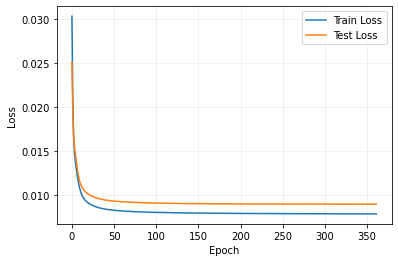

Fold 2 Held Out
Train Loss: 0.008
Test Loss: 0.0088


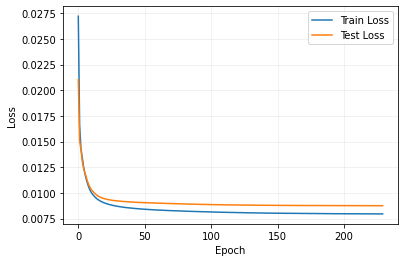

Fold 3 Held Out
Train Loss: 0.0078
Test Loss: 0.009


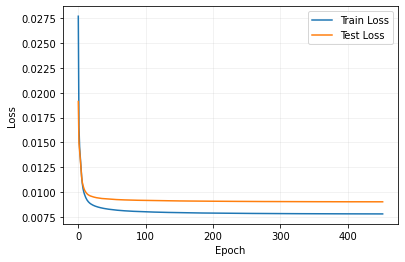

Fold 4 Held Out
Train Loss: 0.0078
Test Loss: 0.0095


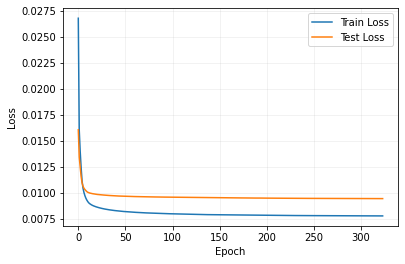

Fold 5 Held Out
Train Loss: 0.0079
Test Loss: 0.0093


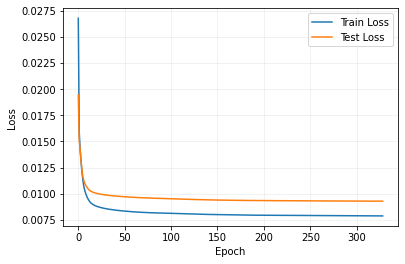

Fold 6 Held Out
Train Loss: 0.0079
Test Loss: 0.0087


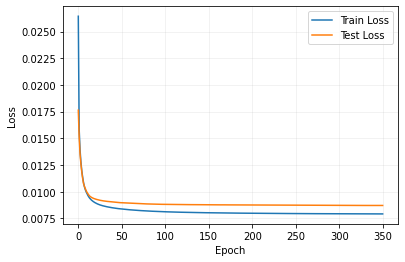

Fold 7 Held Out
Train Loss: 0.0079
Test Loss: 0.0085


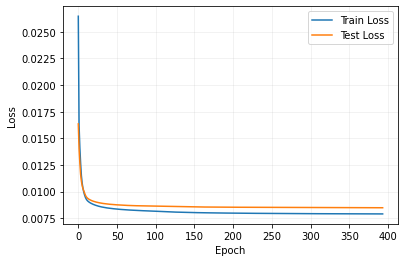

Fold 8 Held Out
Train Loss: 0.0079
Test Loss: 0.0087


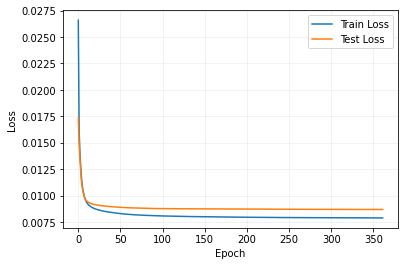

Fold 9 Held Out
Train Loss: 0.0078
Test Loss: 0.0094


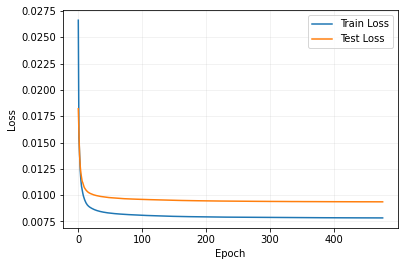

Fold 10 Held Out
Train Loss: 0.0079
Test Loss: 0.0089


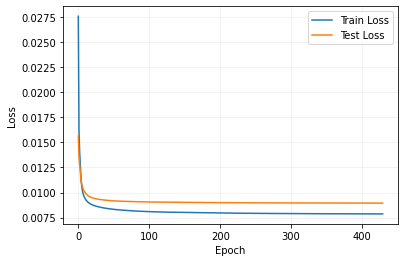

GlyNet Cross-Validation Complete
{'decay': 0.0001, 'patience': 10, 'thres': None, 'n_cutoff': 0, 'weighted': False, 'choice': None, 'in_dim': 272, 'out_dim': 1257, 'n_hidden_layers': 1, 'n_neurons_per_hidden_layer': 100, 'n_folds': 10, 'n_folds_sampled': 10, 'fold_seed': None}


In [ ]:
act_data, pred_data, parameters = train(plot = True)
print(parameters)

In [ ]:
results, avg_number_list = get_results(act_data, pred_data)
print('Average MSE:', round(results['MSE'].mean(), 4))
print('Average R-Squared:', round(results['R-Squared'].mean(), 4))

Average MSE: 0.009
Average R-Squared: 0.3072


In [ ]:
predictable = get_predictable(results, cutoff=0.4)
print(len(predictable), 'Unique CBPs Ready for Prediction:', '\n')
for cbp in predictable:
    samples = predictable[cbp]
    print(*sorted(samples), sep=', ')

41 Unique CBPs Ready for Prediction: 

1003770, 1005771
1003973, 1003974
1004170
1004189
1004210, 1004211, 1004212, 1004213
1004214, 1004215, 1004216, 1004217
1004432, 1004433
1004452, 1004453
1004456
1004459, 1004460, 1004461, 1004462
1004464, 1004465, 1004466, 1004467, 1004468
1004473
1004484, 1004485
1004494
1004574, 1004575
1004579
1004610, 1004611, 1004612
1004640
1004659
1004663
1004667
1004685
1004791, 1004792
1004808
1004841, 1004854
1004857
1004866
1005068, 1005903
1005380
1005396
1005400, 1005401, 1005402, 1005403
1005510
1005764
1005828
1005859
1005926, 1005927, 1005928
1005929, 1005930
1005931
1005981, 1005982
1006009



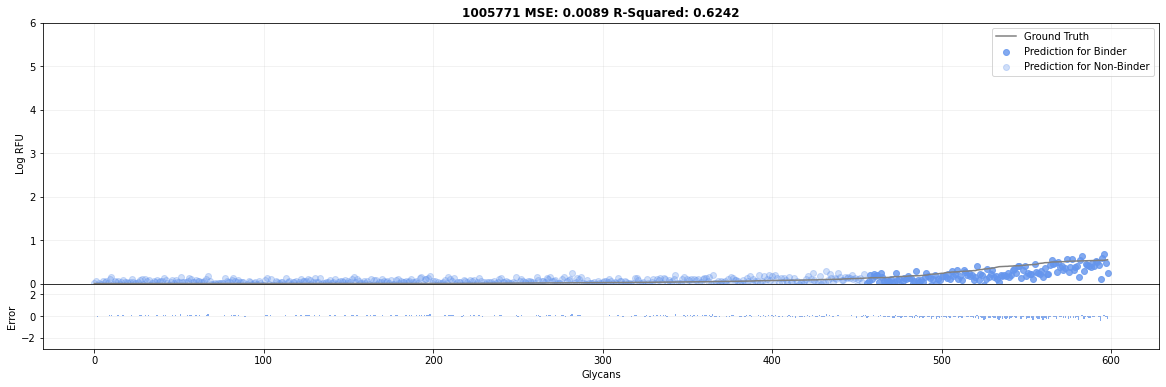

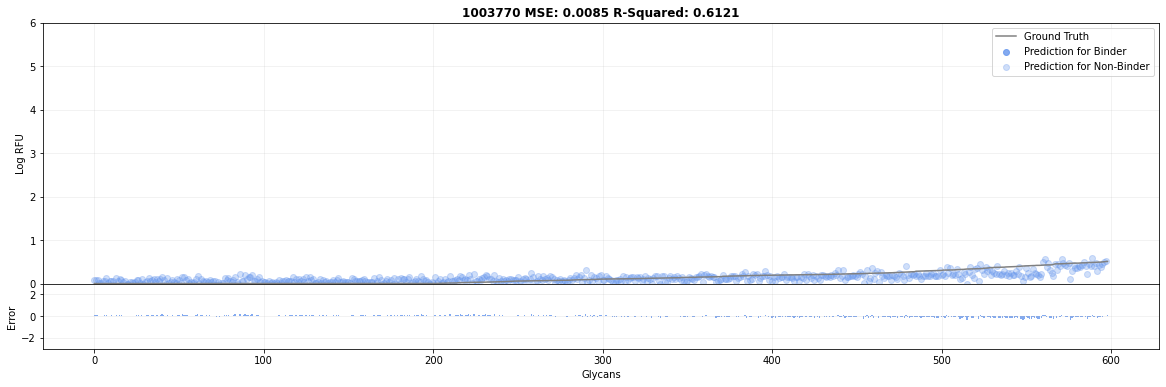

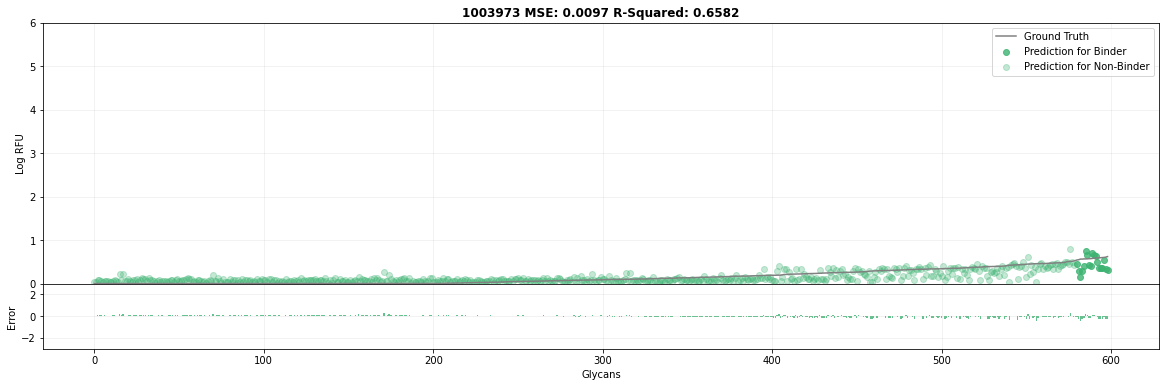

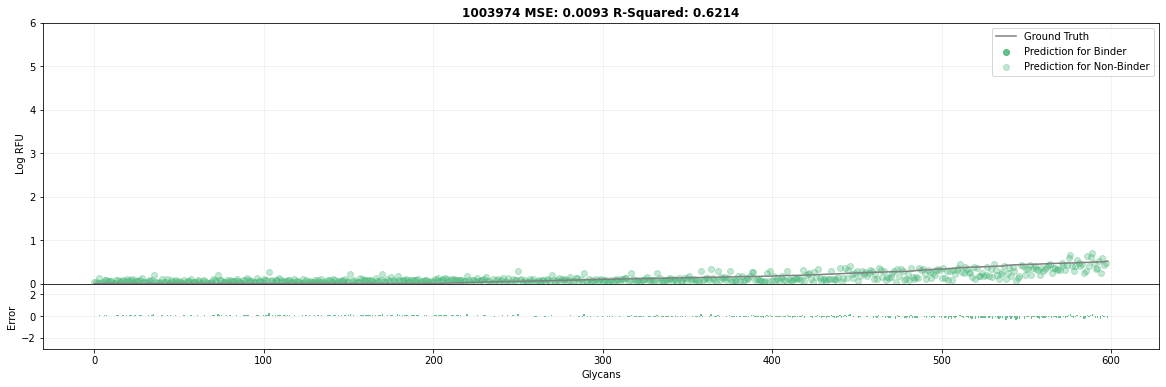

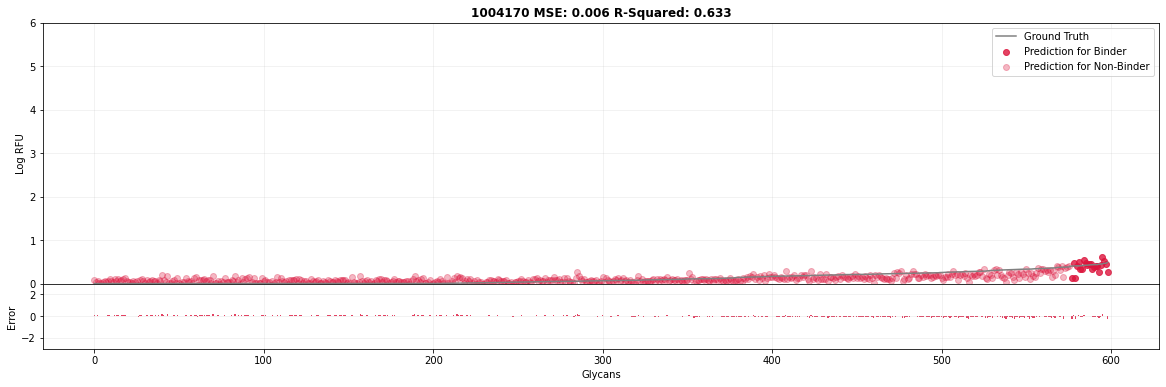

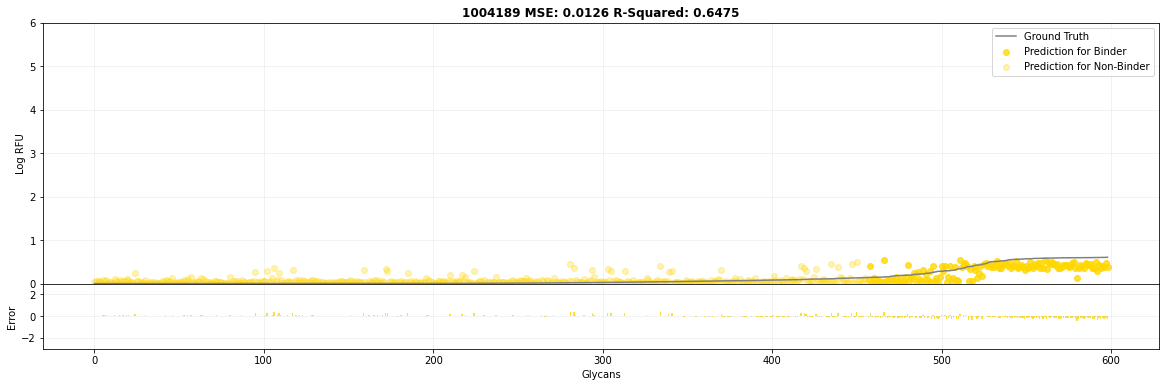

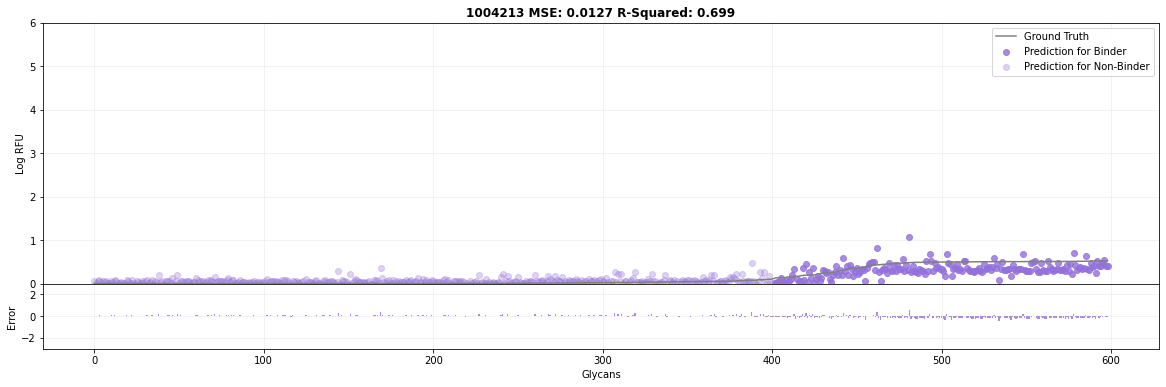

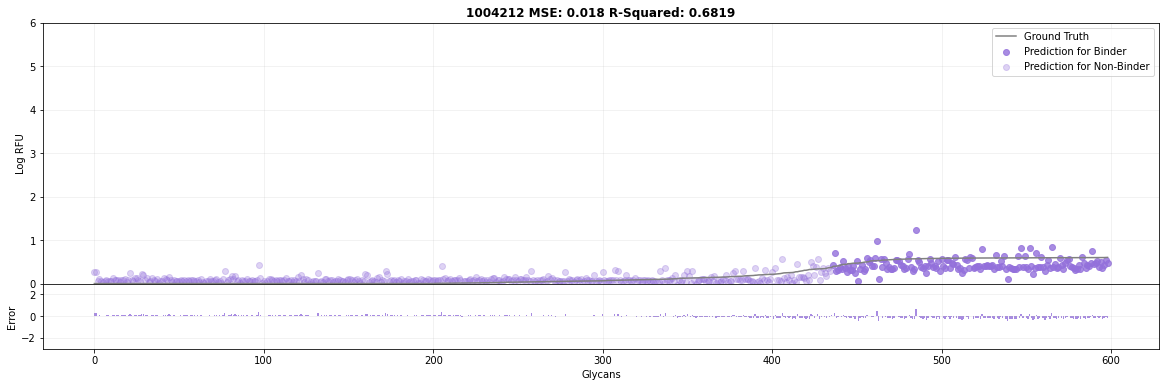

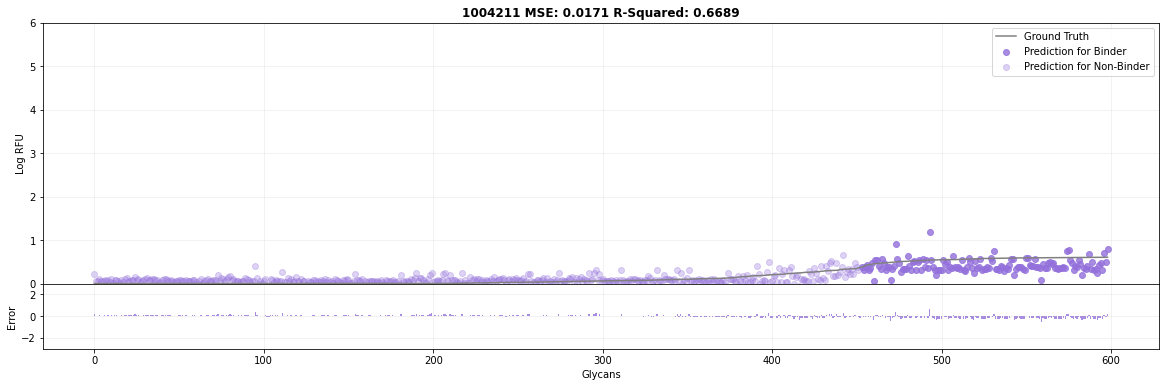

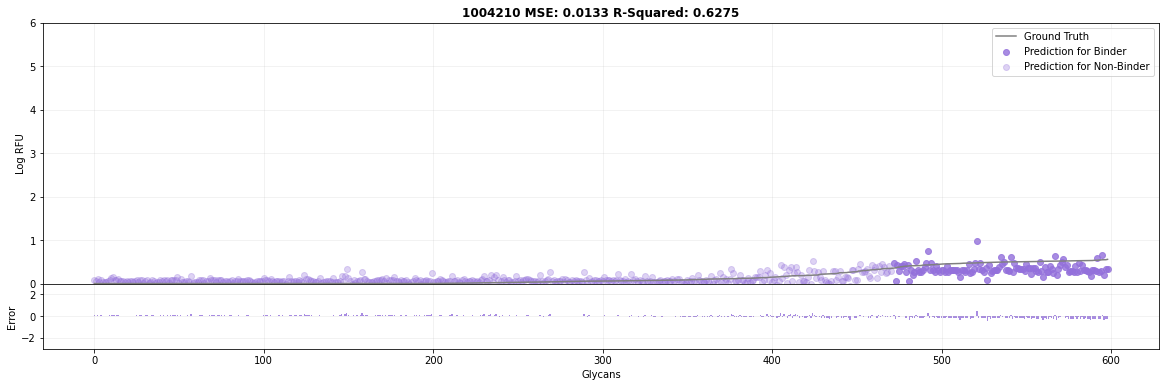

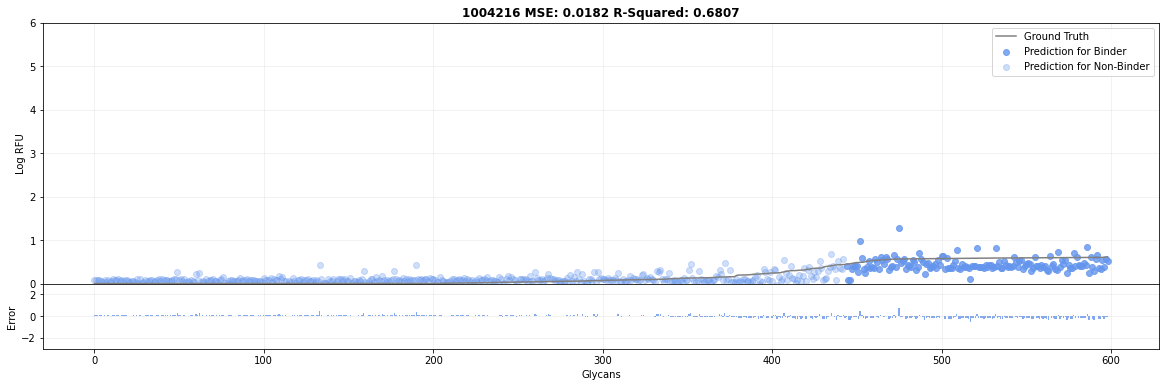

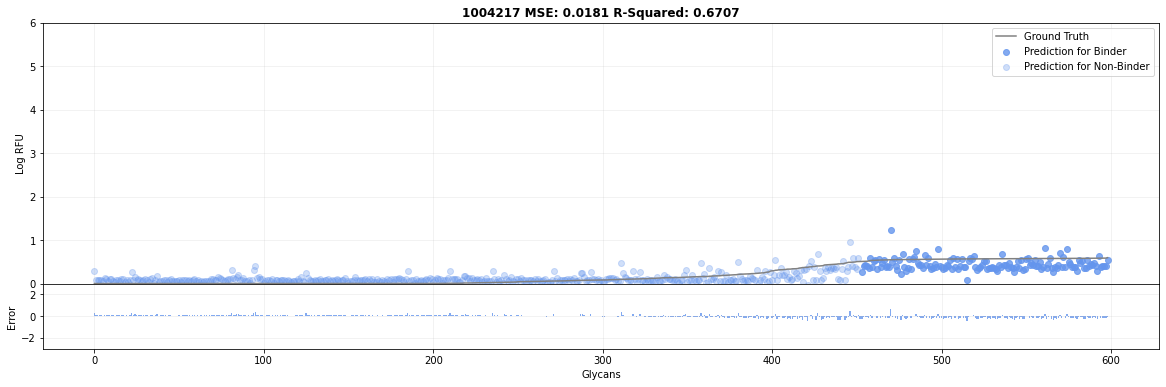

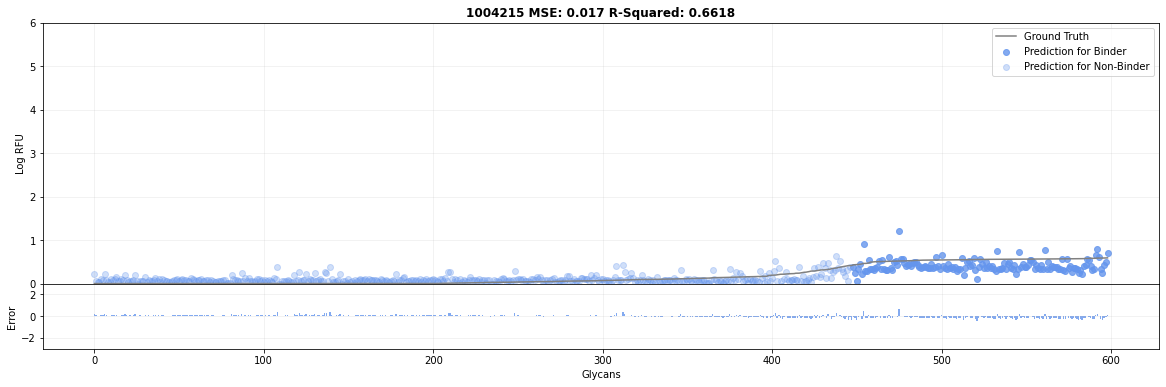

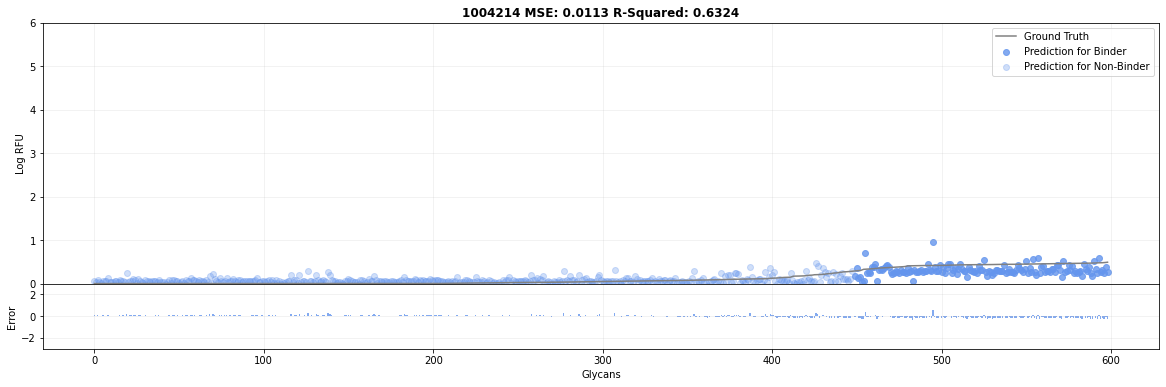

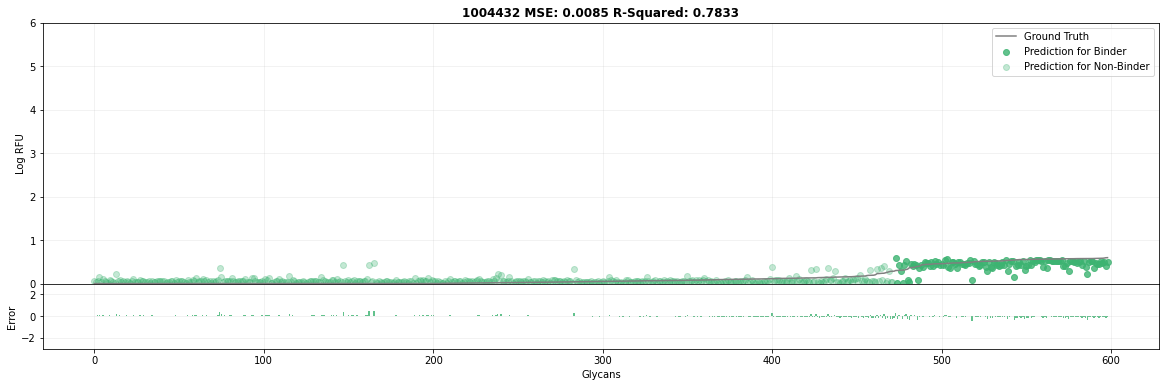

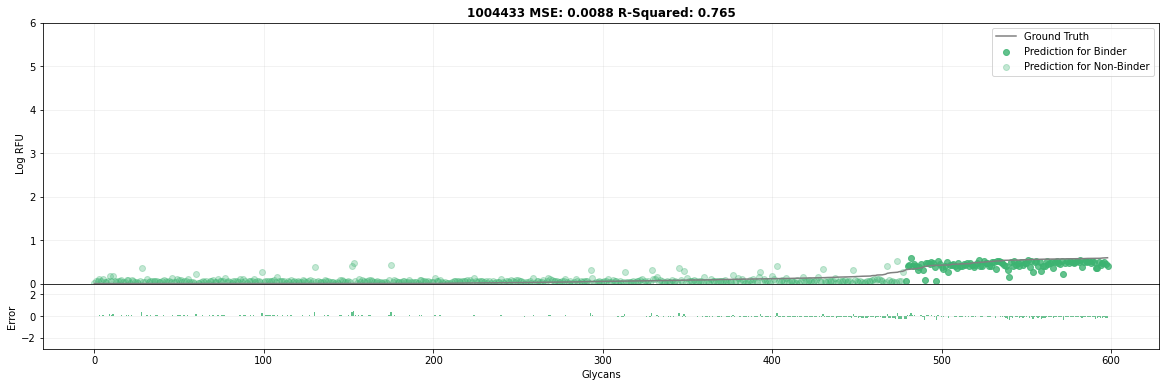

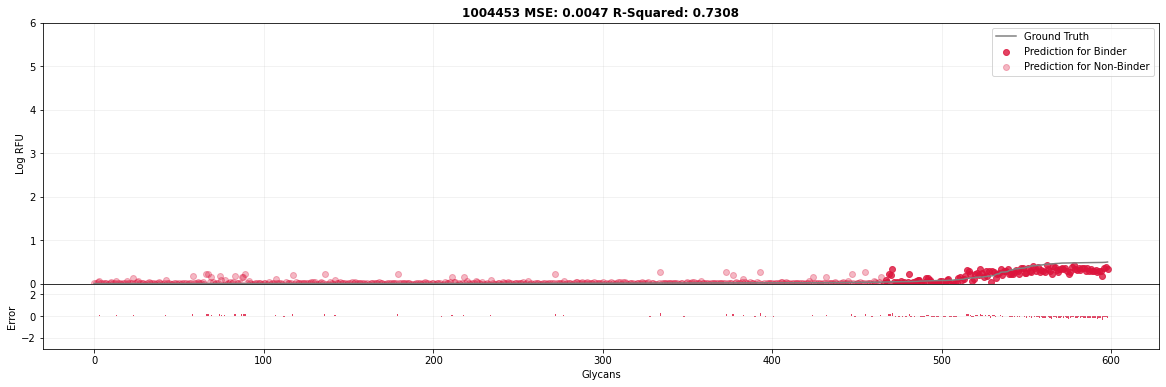

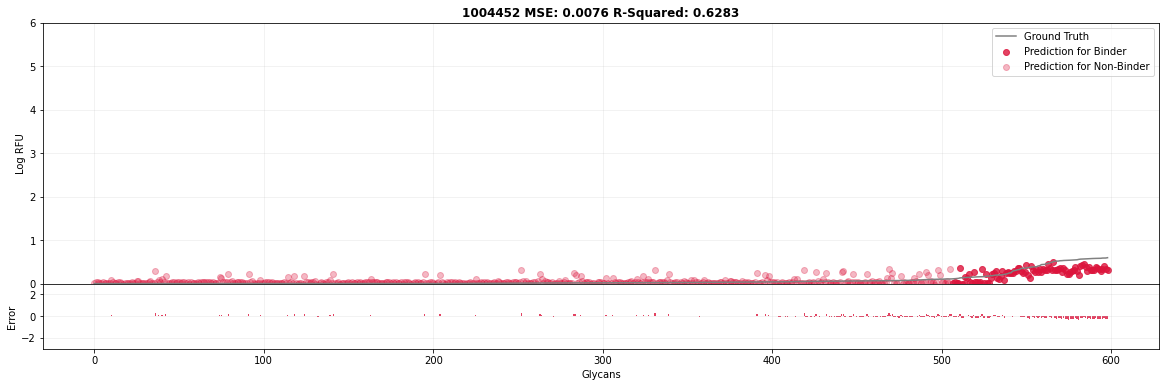

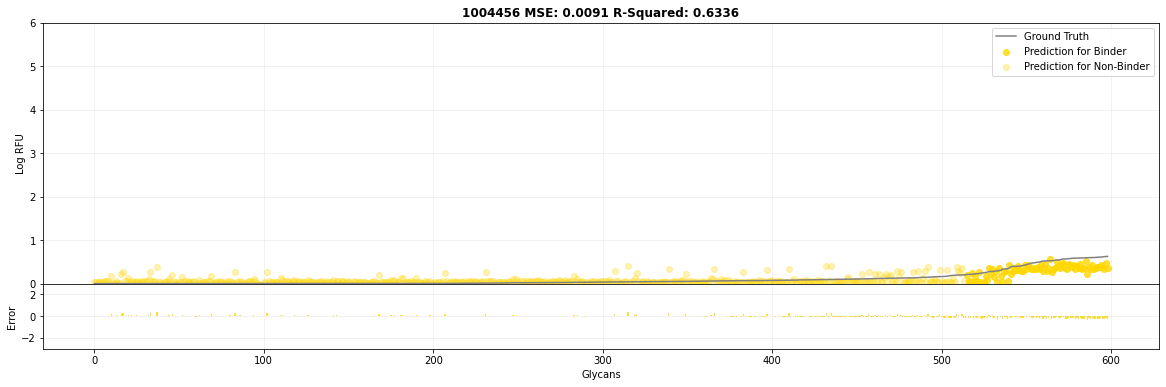

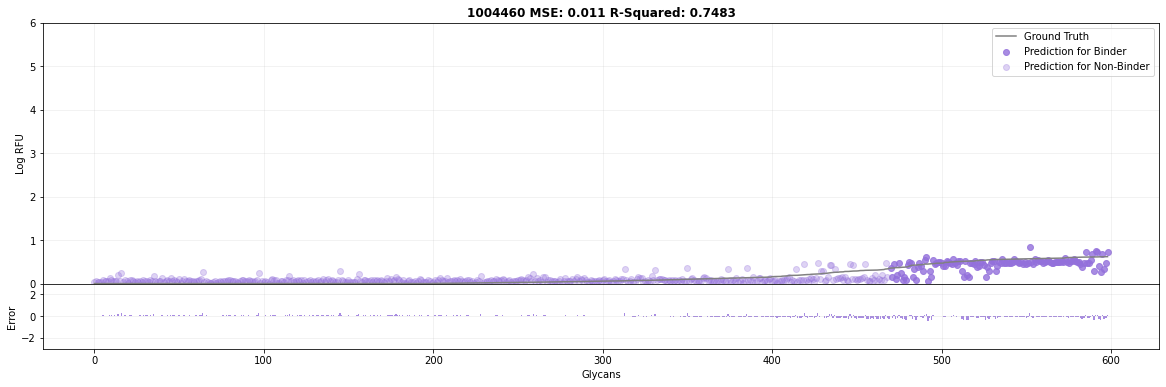

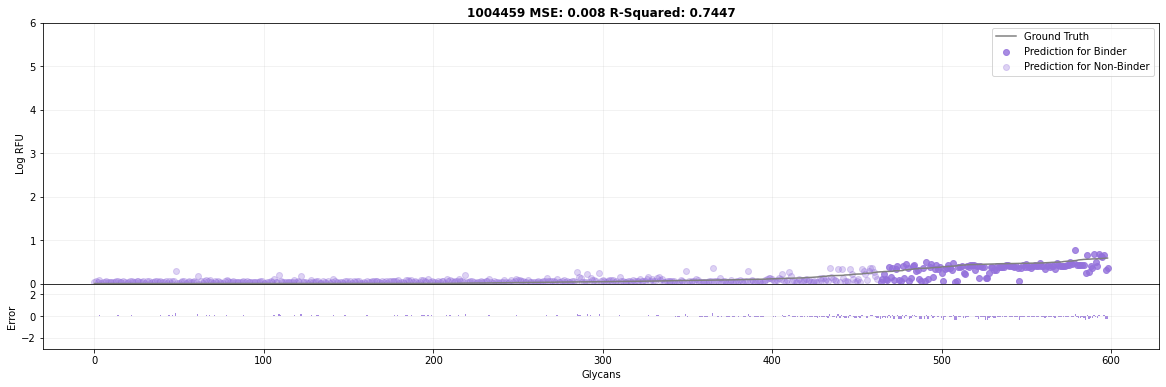

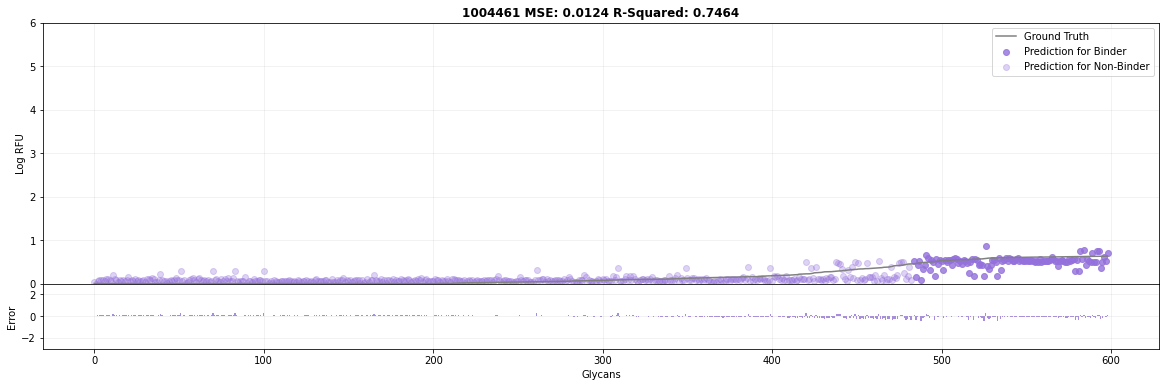

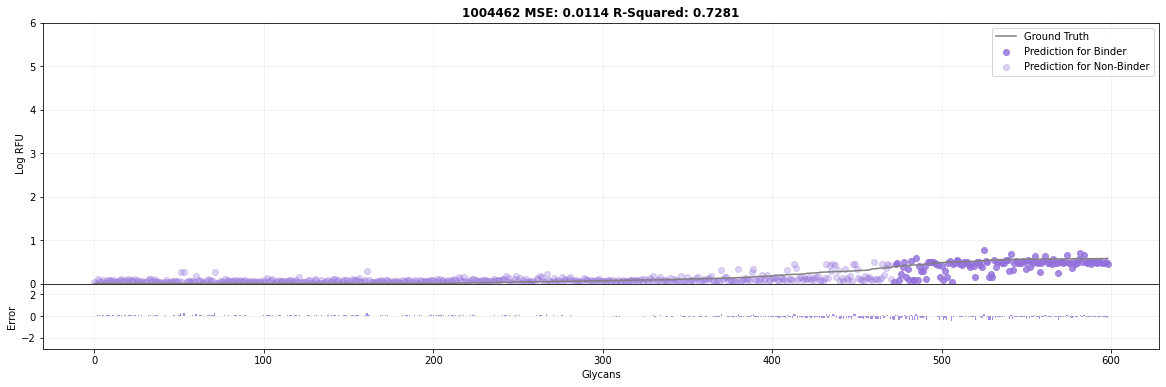

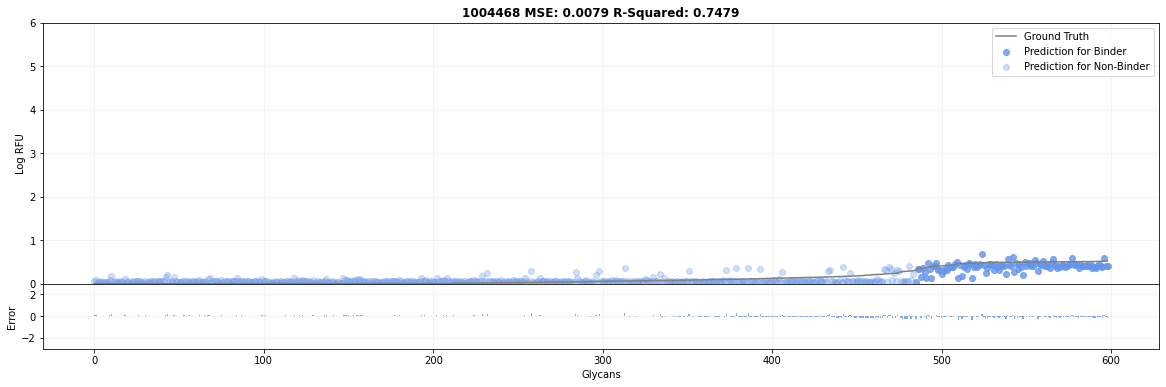

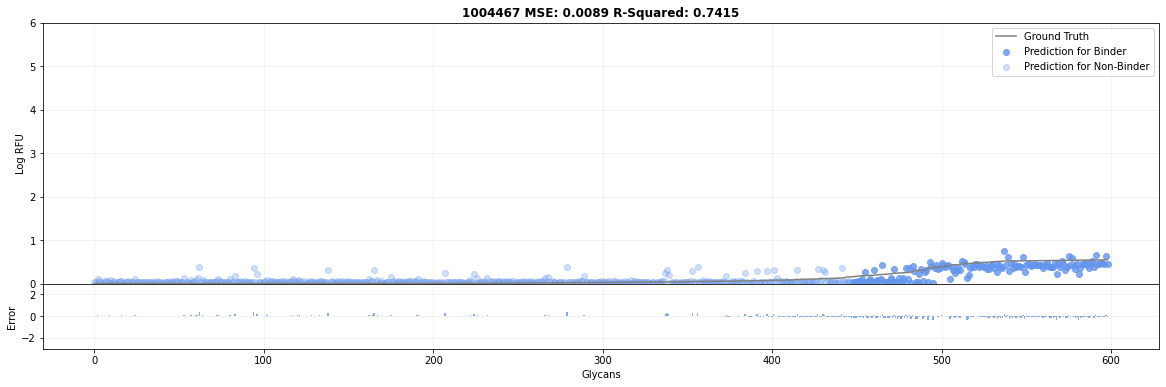

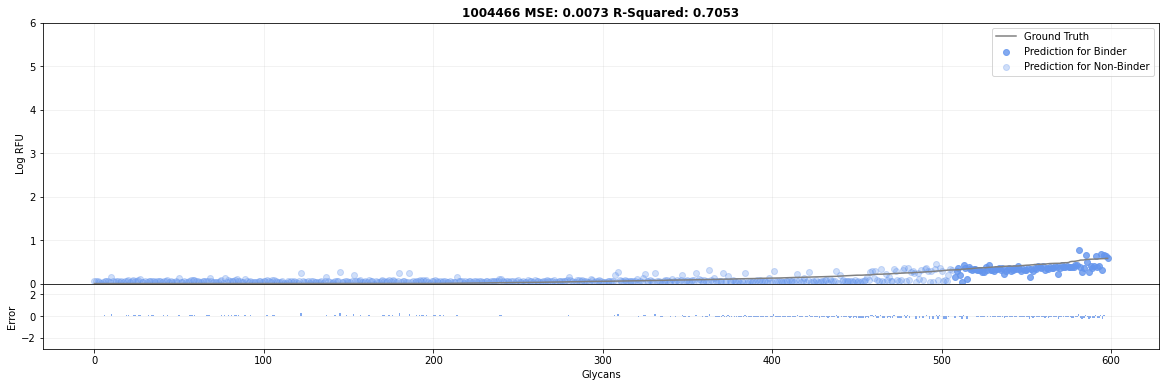

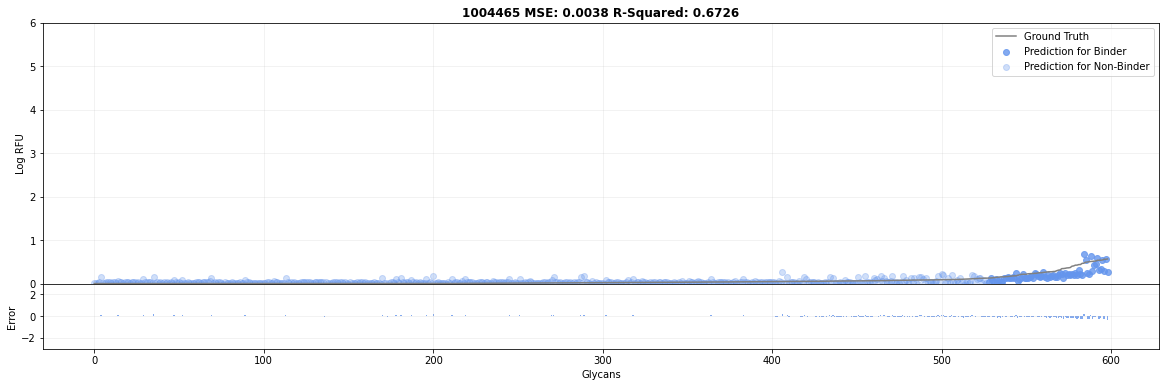

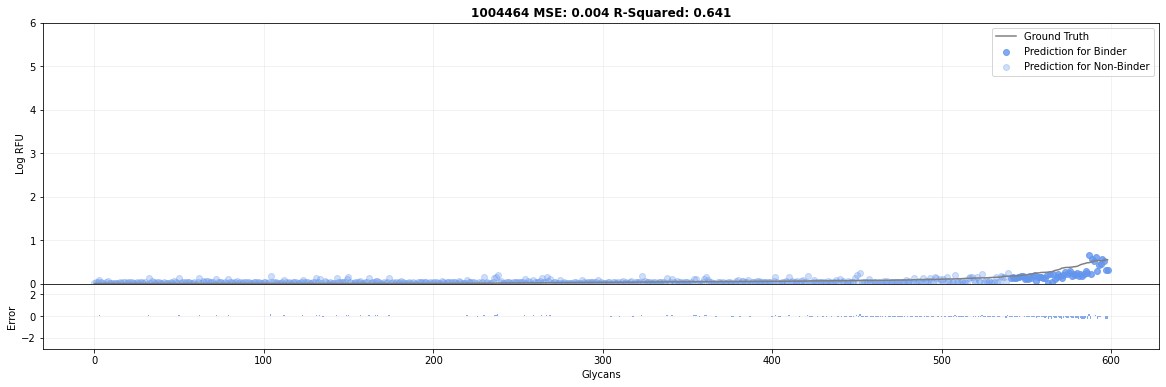

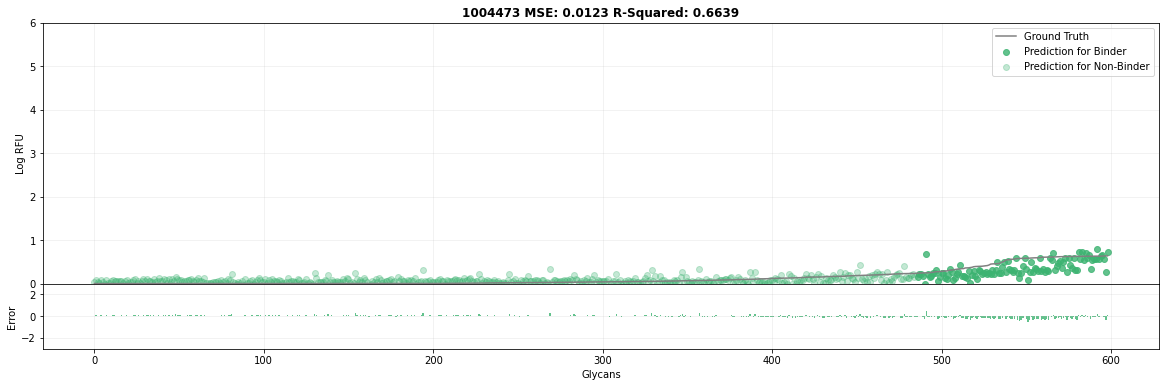

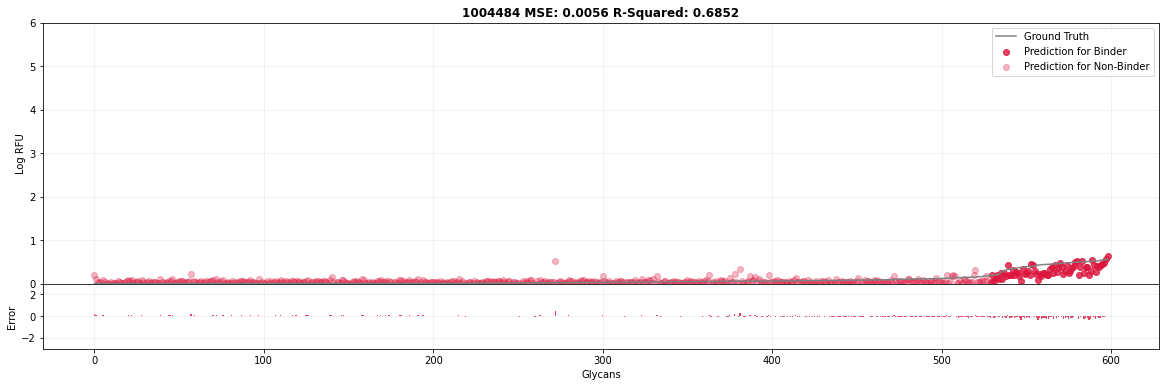

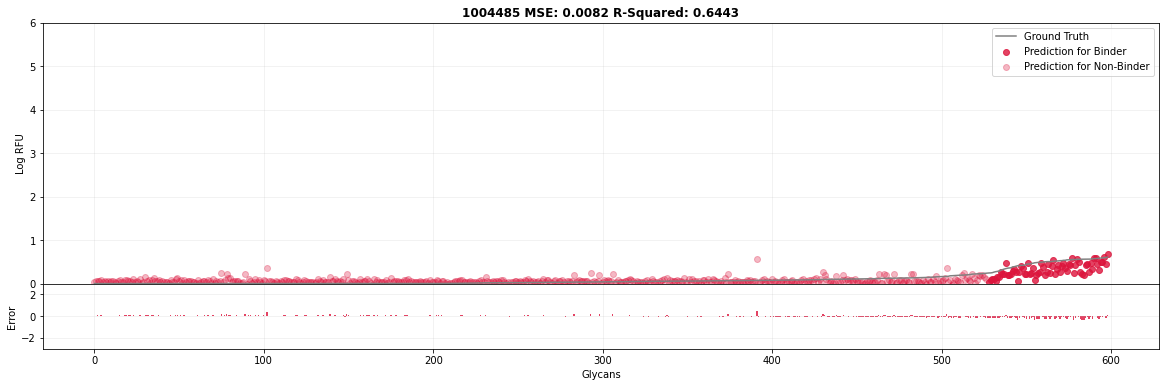

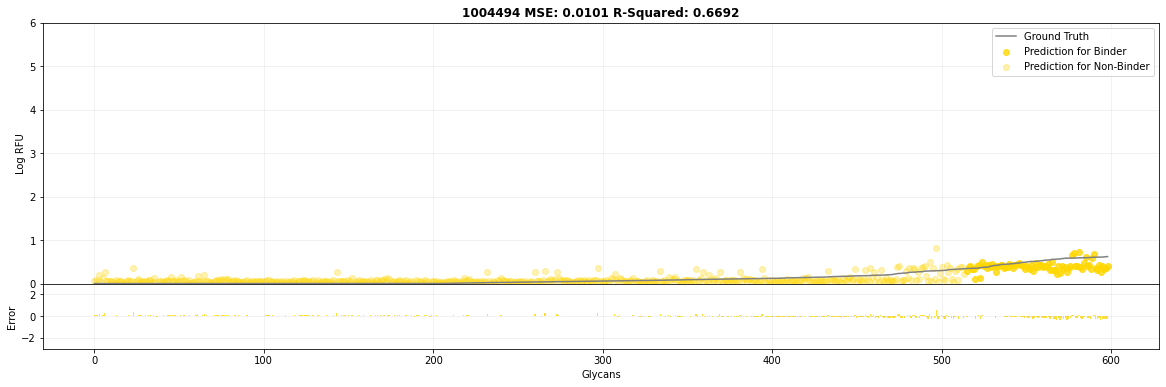

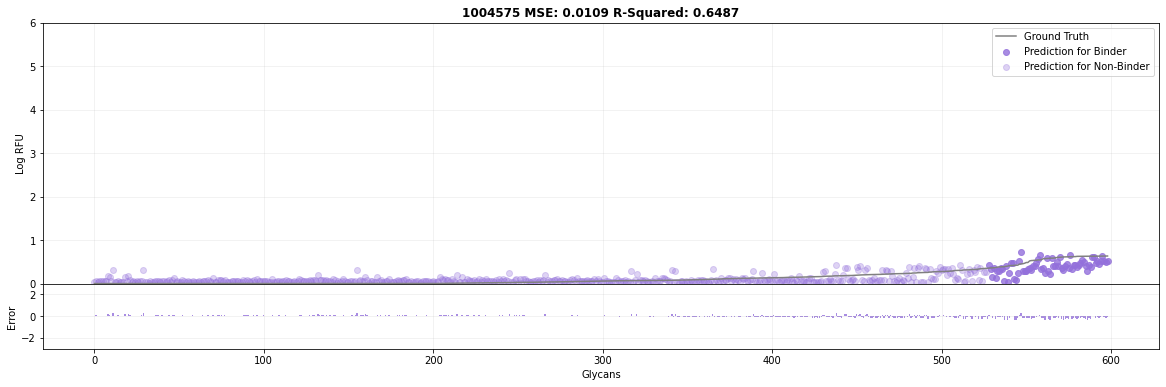

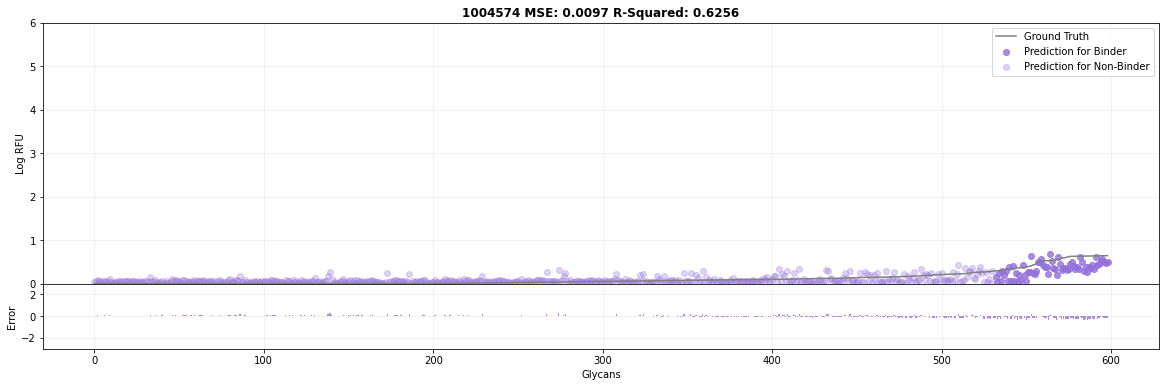

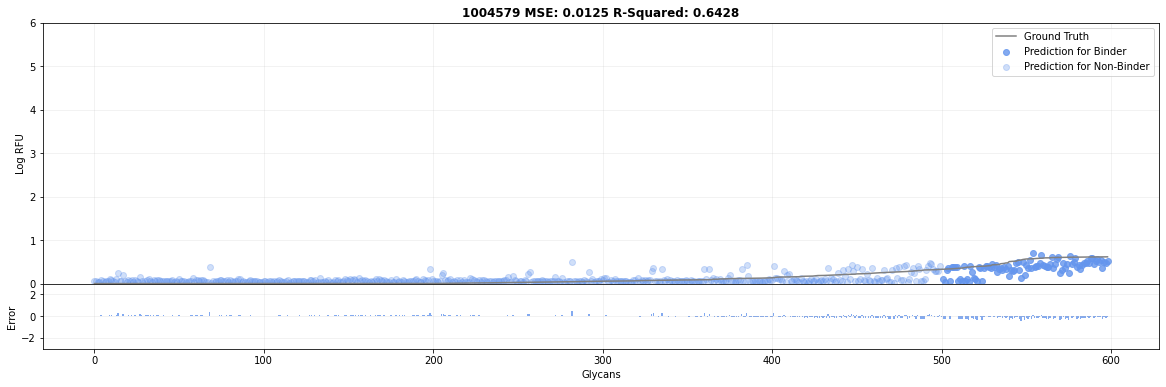

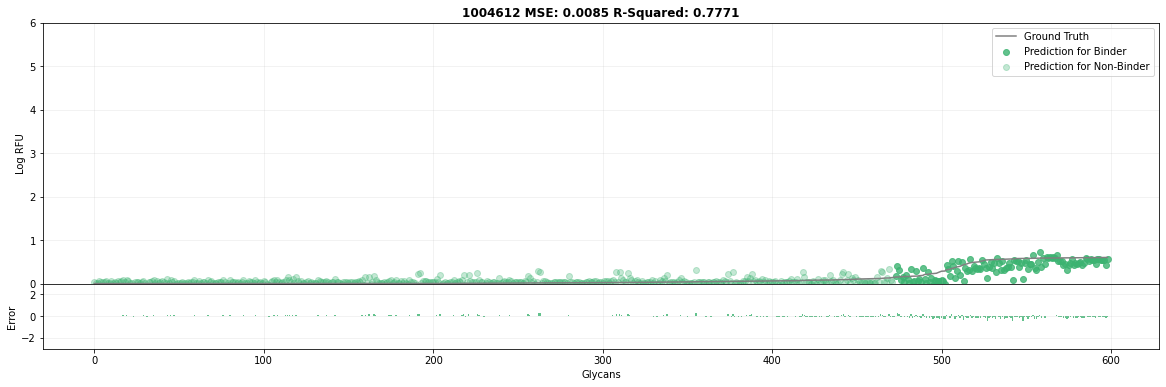

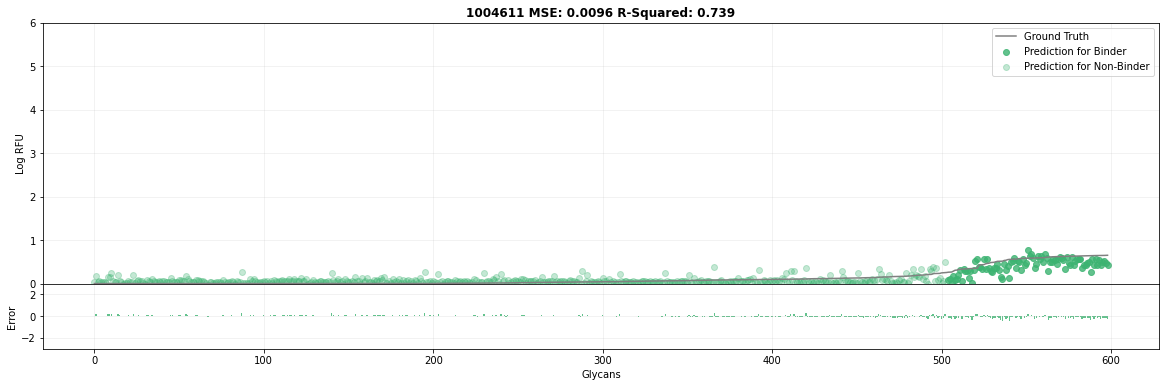

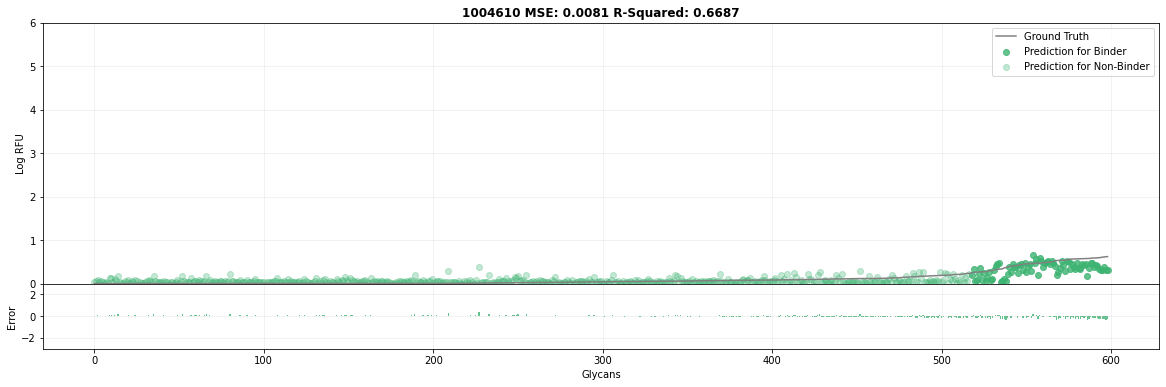

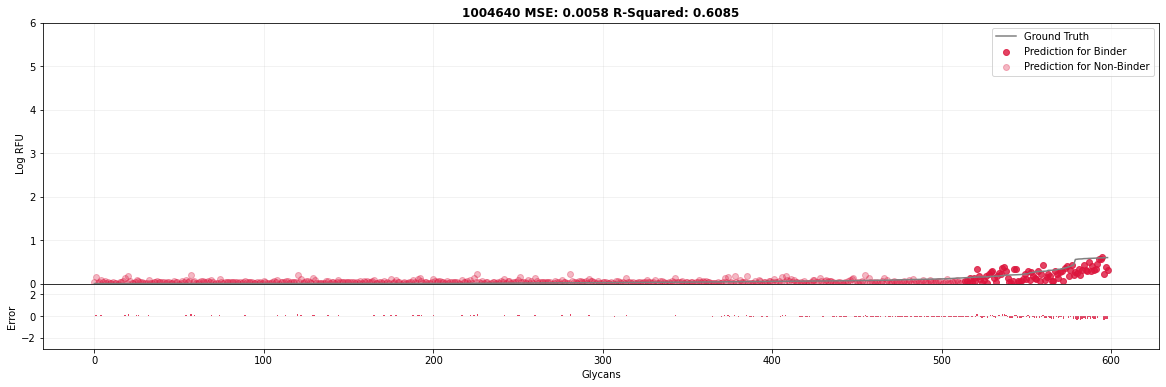

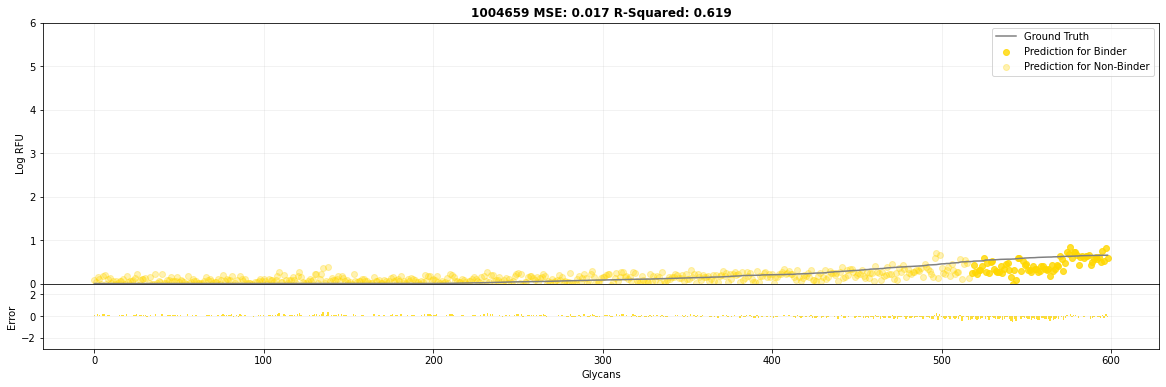

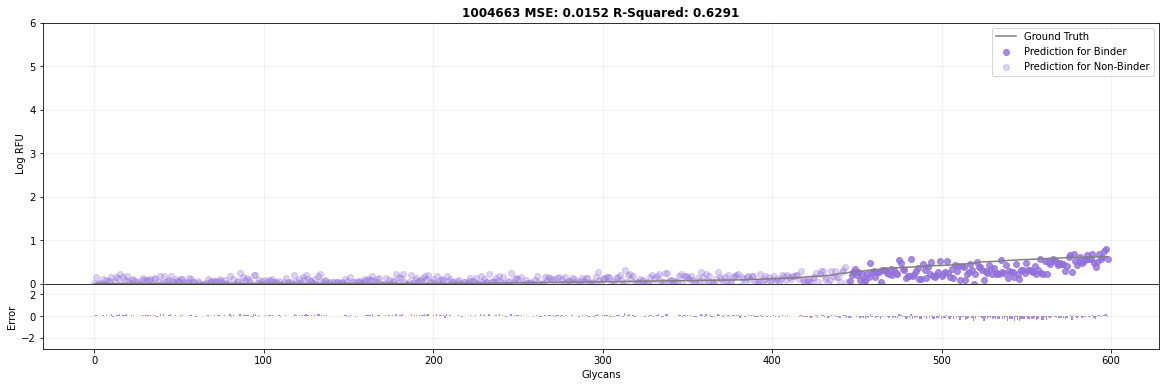

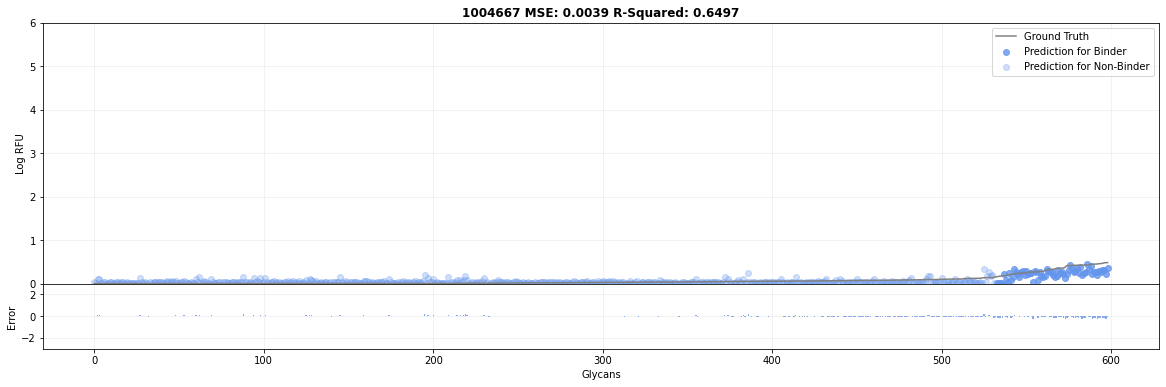

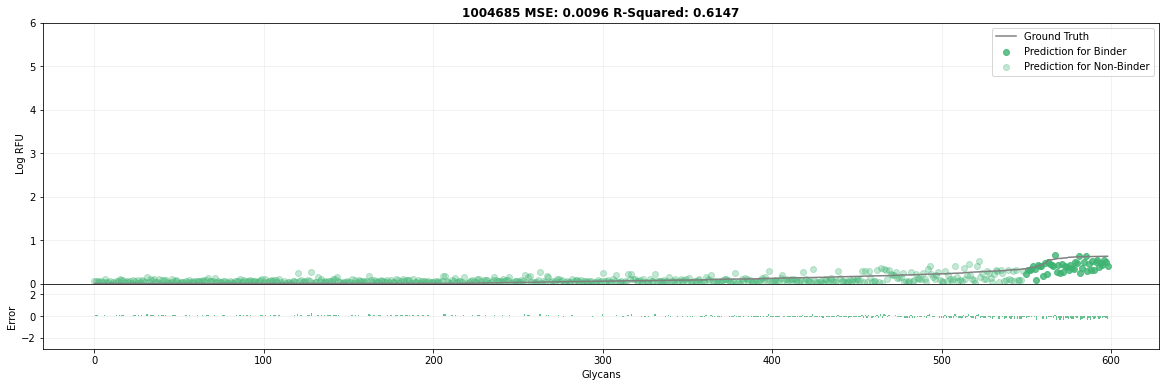

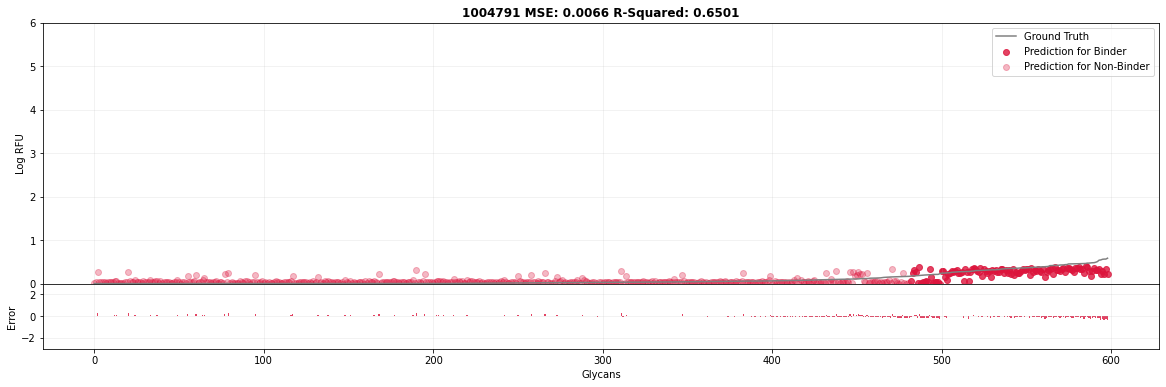

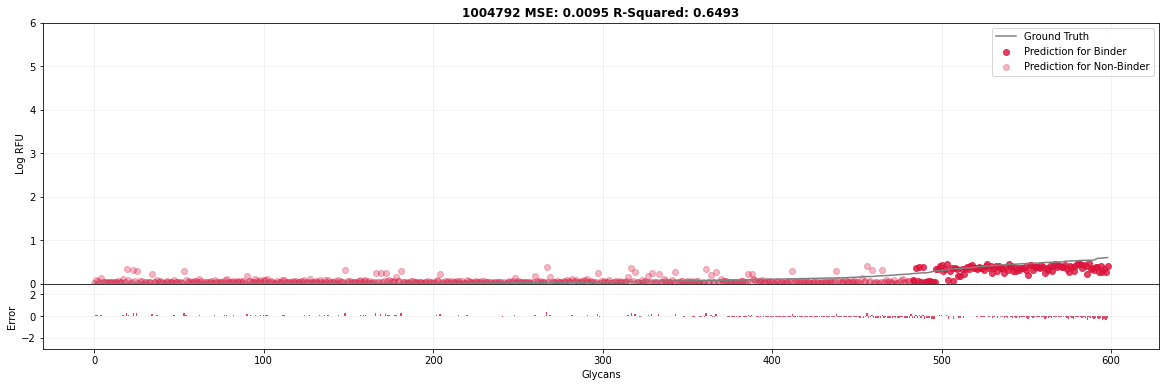

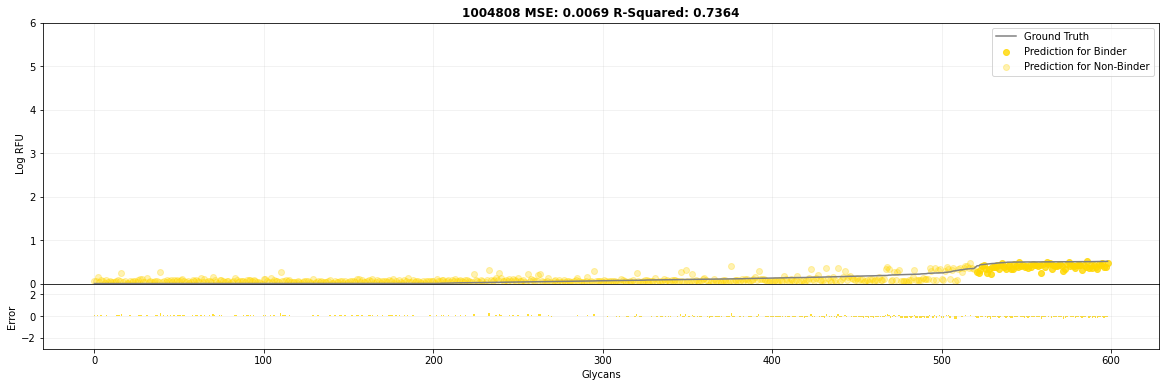

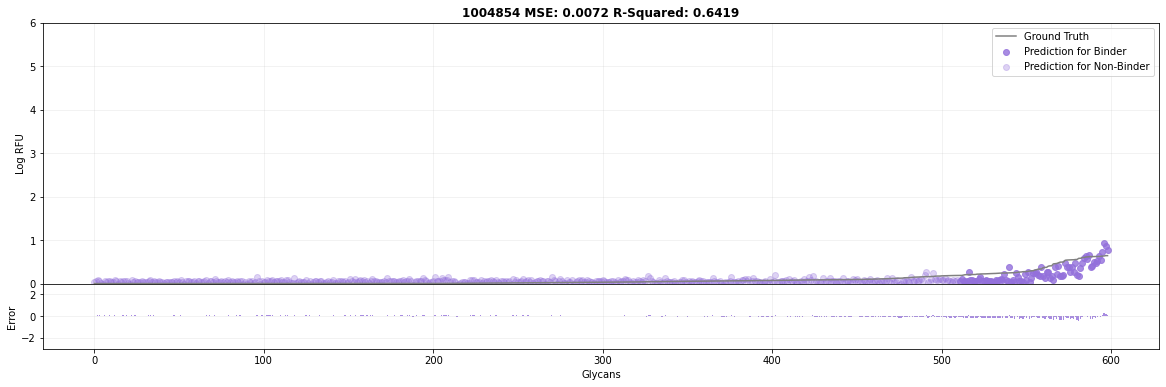

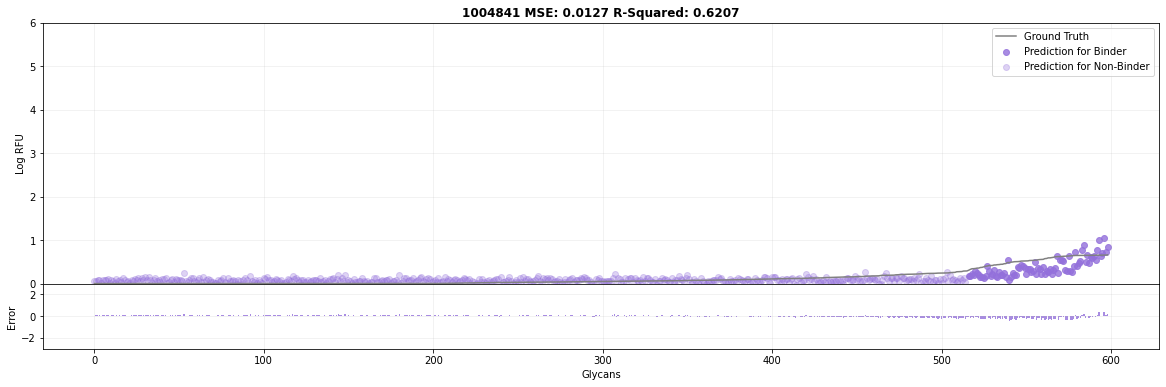

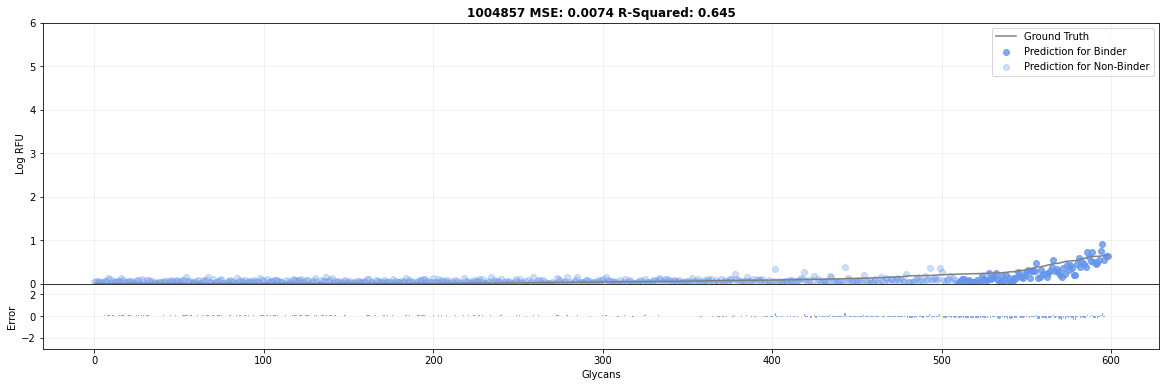

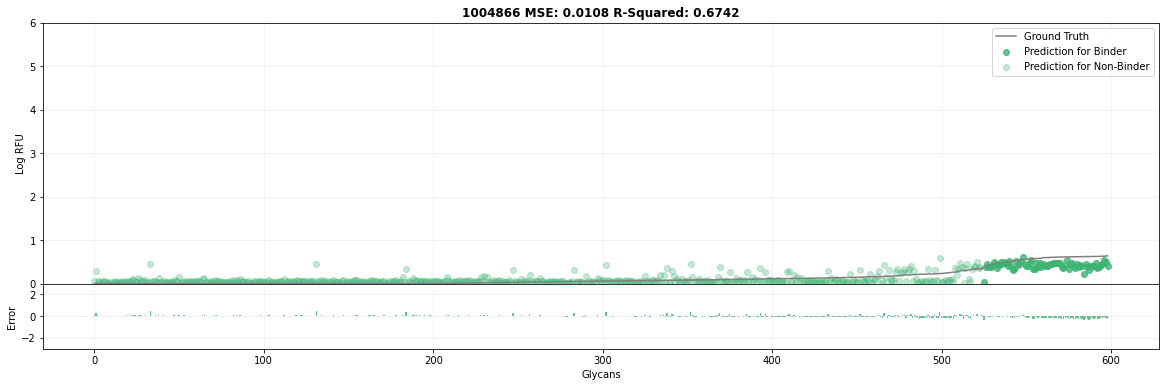

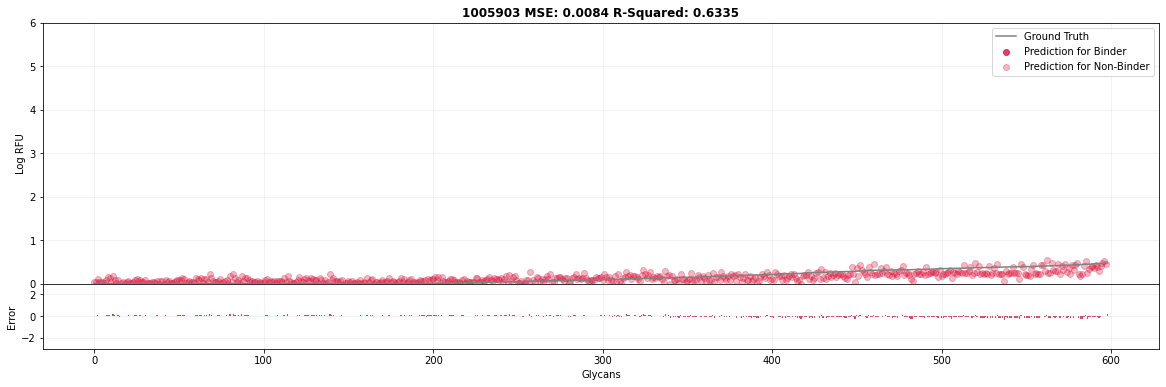

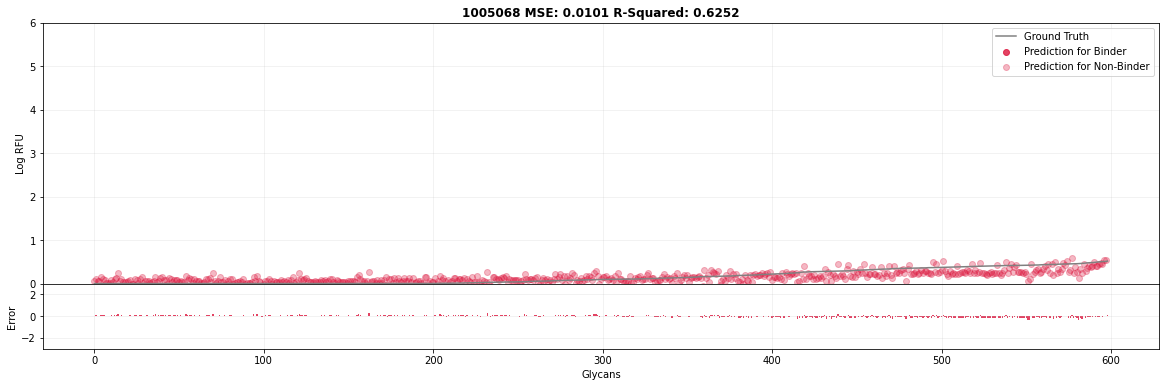

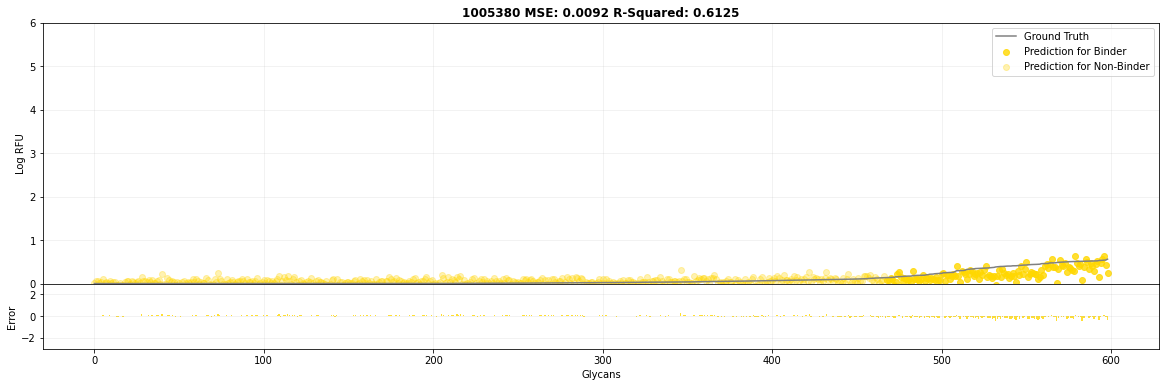

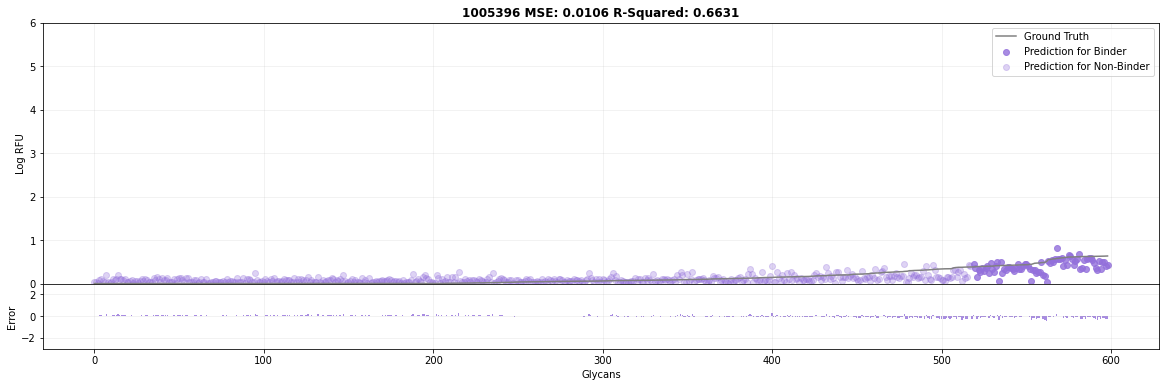

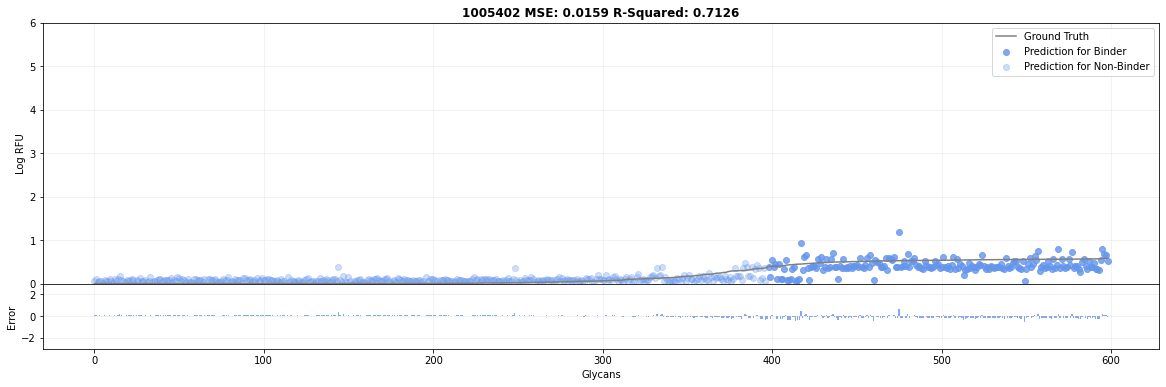

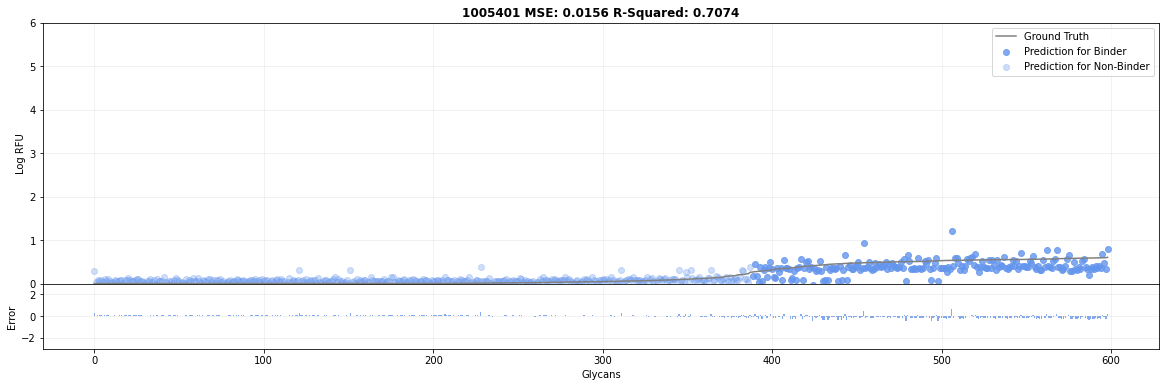

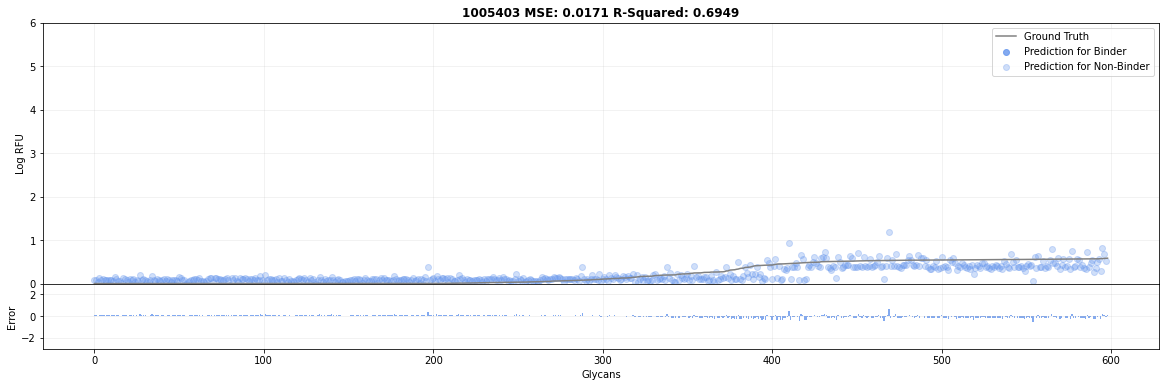

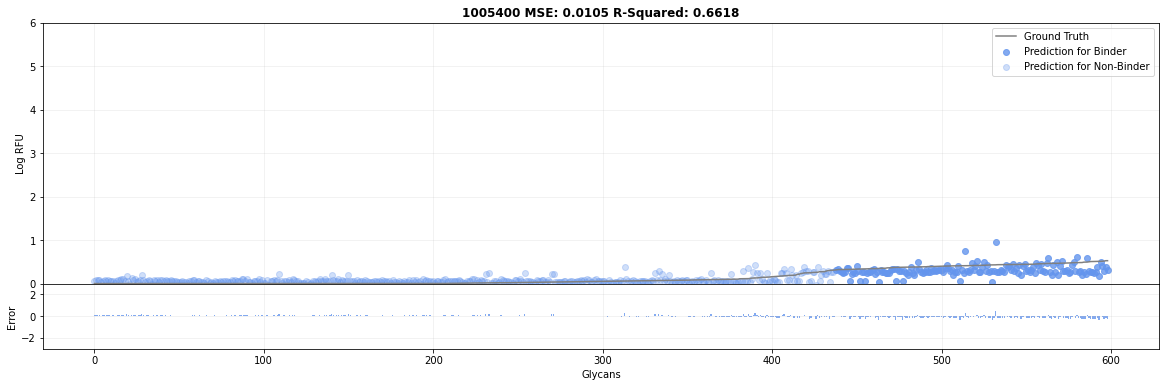

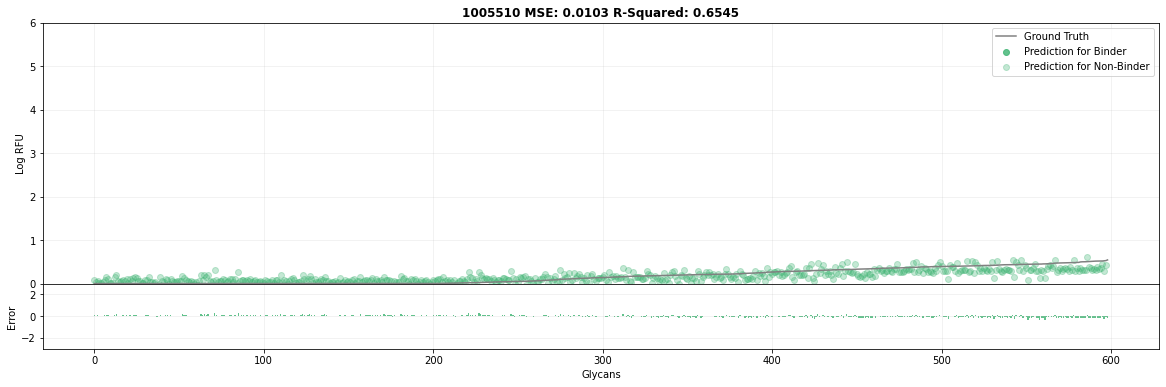

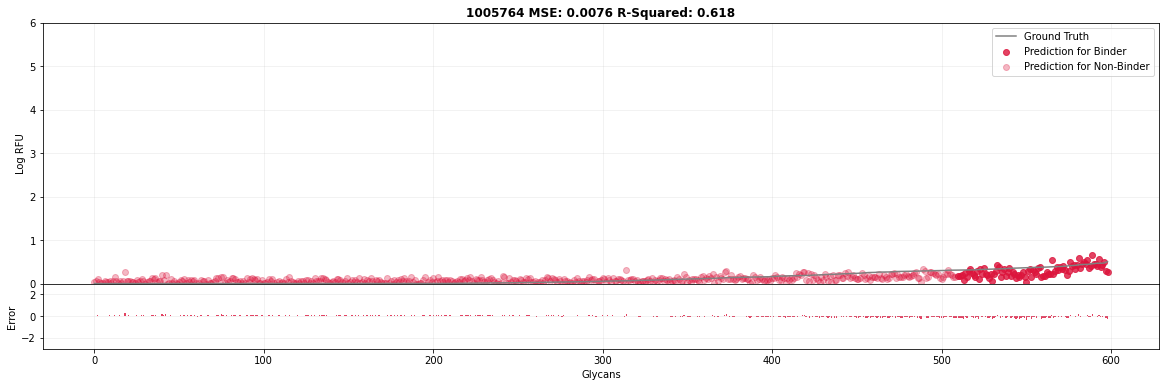

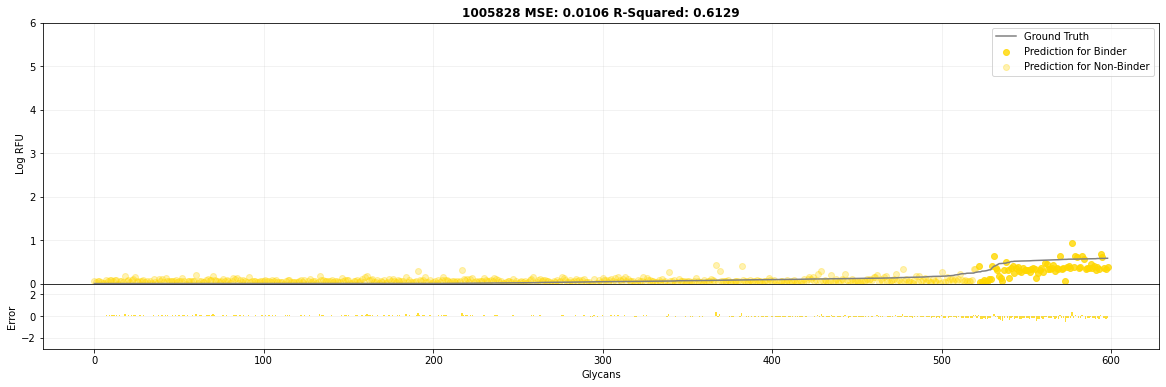

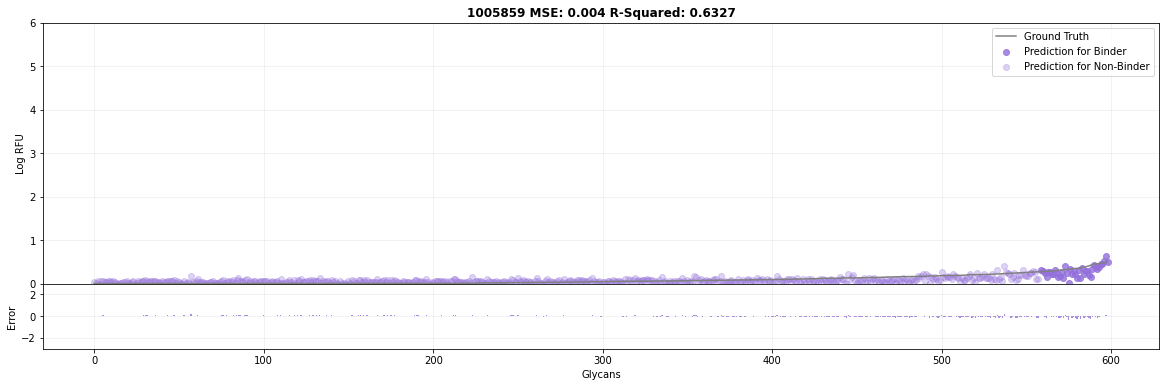

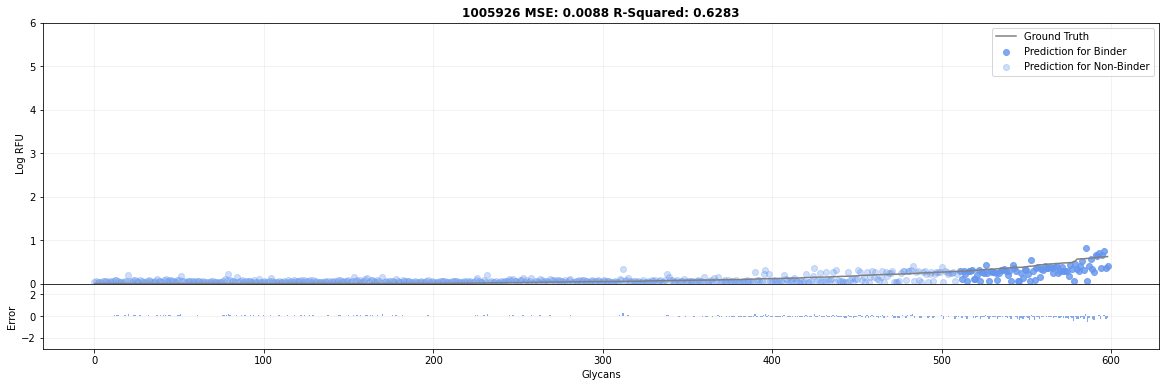

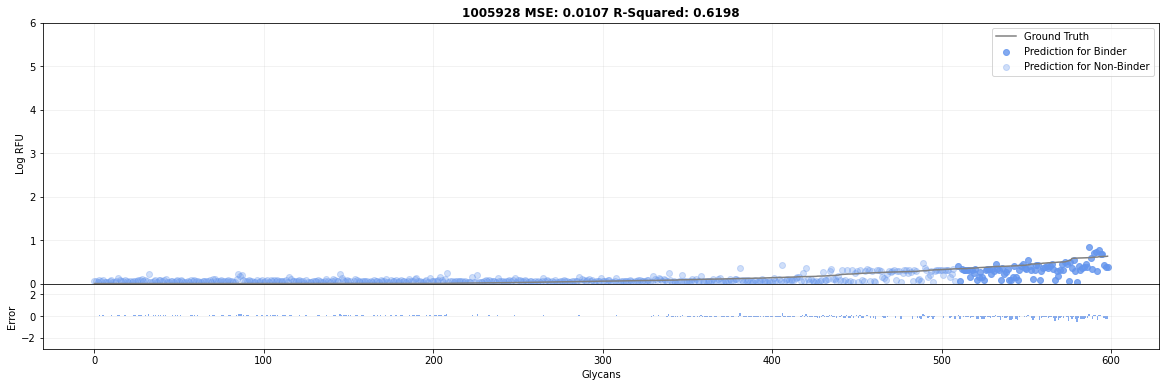

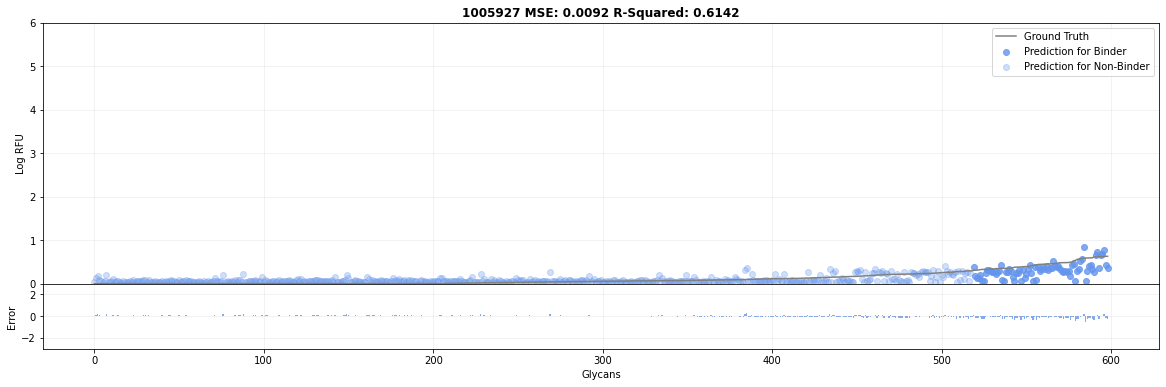

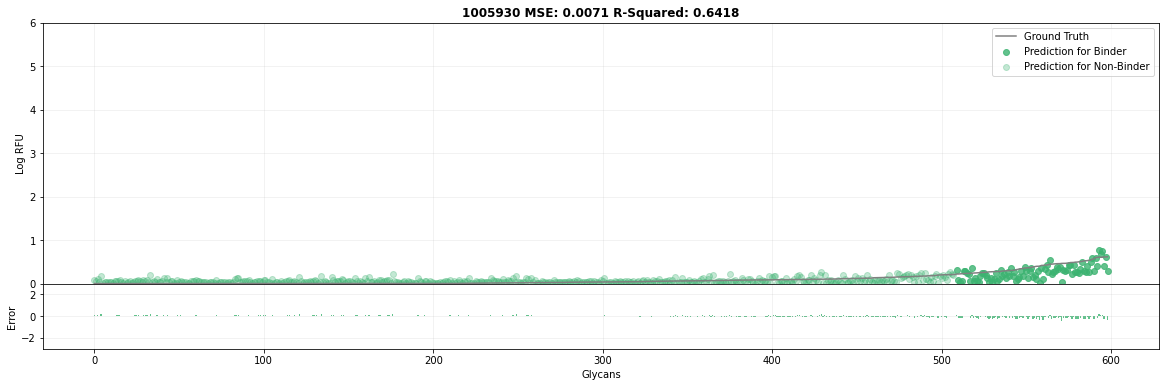

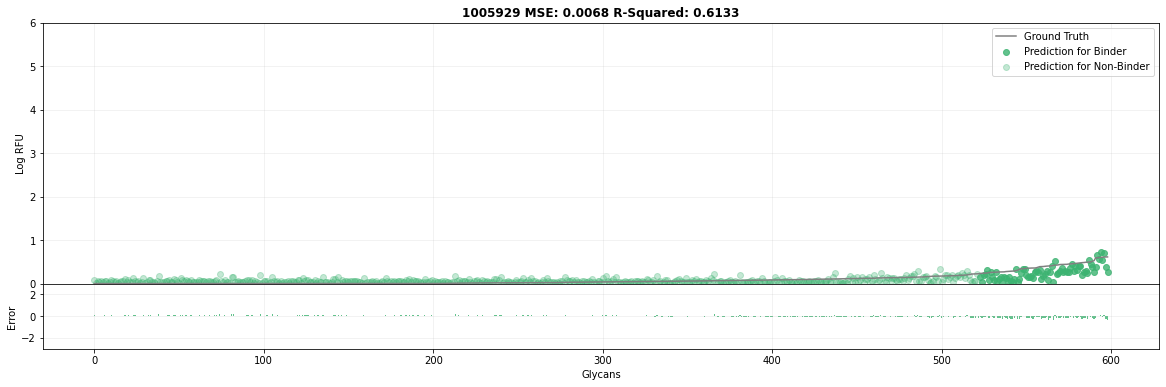

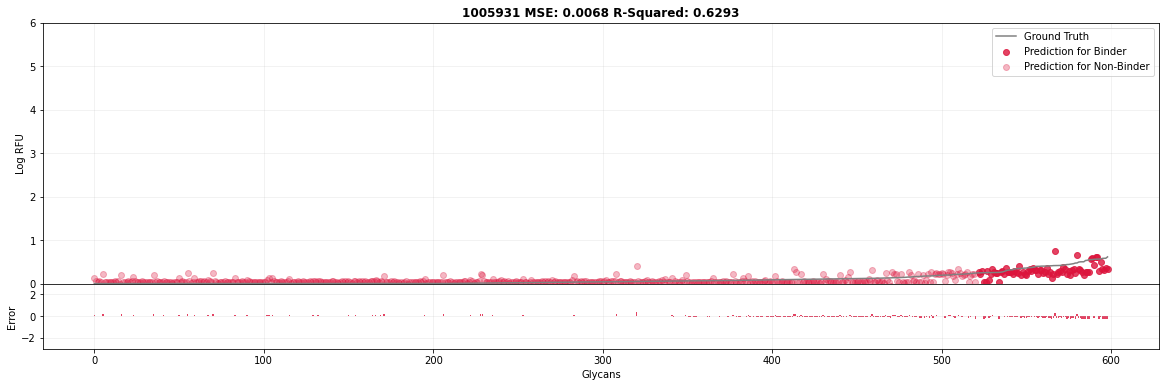

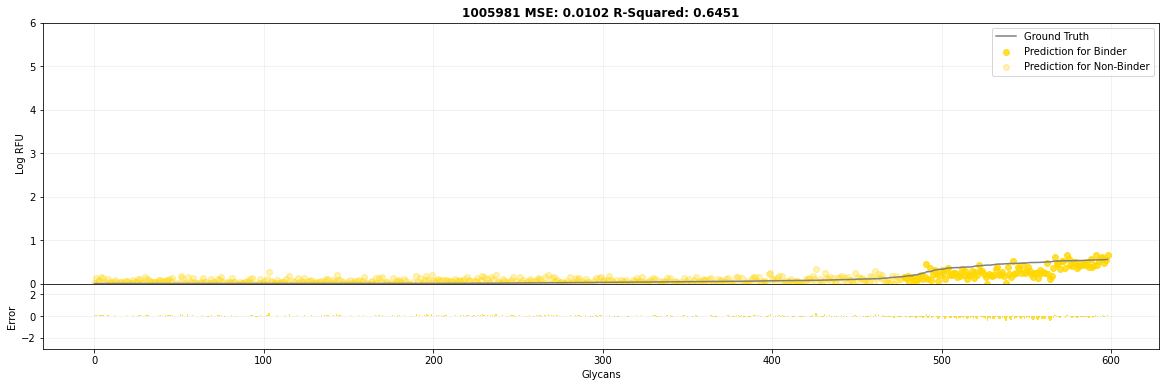

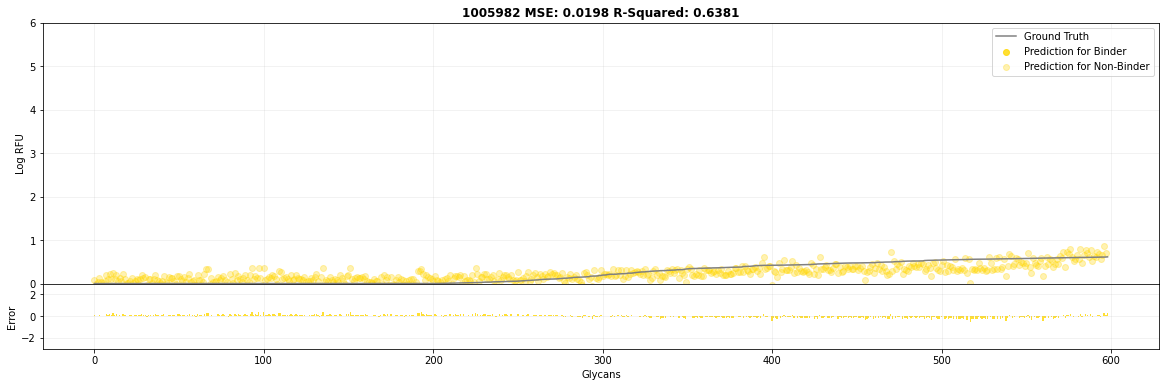

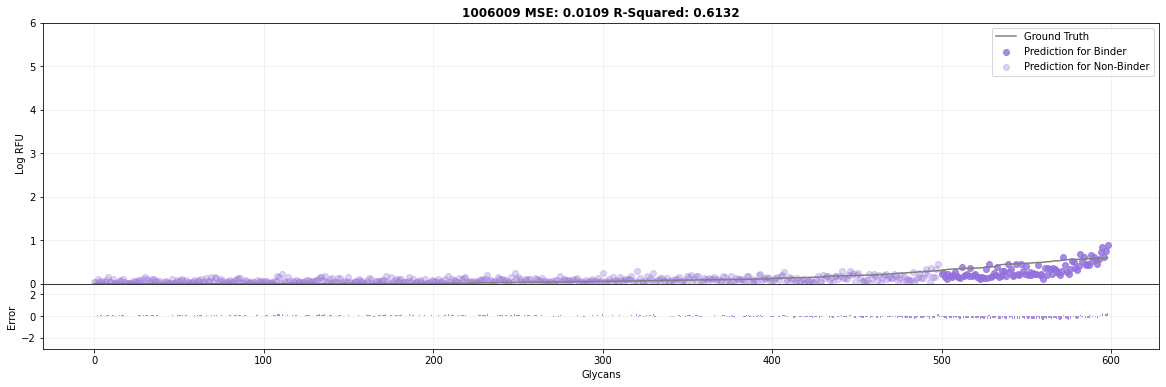

In [ ]:
colors = ['cornflowerblue', 'mediumseagreen', 'crimson', 'gold', 'mediumpurple'] * 114
for i, cbpId in enumerate(predictable):
    for sample in predictable[cbpId]:
        plot_scatter(act_data[sample].values, pred_data[sample].values, sample, colors[i])